['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vechiles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vechiles' 'Vechiles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road'
 'Slippery road' 'Road narrows on the right' 'Road work' 'Traffic signals'
 'Pedestrians' 'Children crossing' 'Bicycles crossing'
 'Beware of ice/snow' 'Wild animals crossing'
 'End of all speed and passing limits' 'Turn right ahead'
 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' 'Keep right' 'Keep left' 'Roundabout mandatory'
 'End of no passing' 'End of no passing by vechiles over 3.5 metric tons']


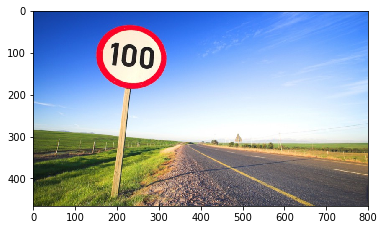

label=[Speed limit (30km/h)] id=1 conf=0.9894695281982422
Draw: label=[Speed limit (30km/h)] id=1 conf=0.9894695281982422
label=[End of no passing] id=41 conf=0.14864680171012878
No Draw: label=[End of no passing] id=41 conf=0.14864680171012878


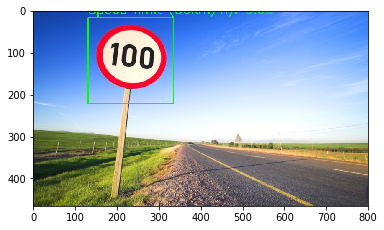

In [12]:
import os
import sys
import cv2
#brew install opencv
#pip install opencv-python
import numpy as np
from pandas import read_csv
#pip install moviepy
#pip install requests
from moviepy.editor import *
from matplotlib import pyplot as plt 
import keras
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import tensorflow as tf


infile="../picture/v.mp4"
outfile="../picture/v-output.mp4"

'''
Code adapted from:
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

'''

IMG_SHAPE=[32,32,3]
INPUT_SHAPE=[1,32,32,3]
L2_LAMBDA = 0.0001   
WEIGTHS_PATH="../doc/weights_mltscl_dataaug.hdf5"
OUTPUT_DIM=43
LR = 0.0001
CONF_THRES=0.5

# Labels of circlur signs
cir_cls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16,
           17, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]

signnames = read_csv("../doc/signnames.csv").values[:, 1]

print(signnames)

def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    Ref: https://stackoverflow.com/questions/34968722/softmax-function-python
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def build_mltscl():
    """
    Build multiscale CNN. The last layer must be logits instead of softmax.
    Return a compiled Keras model.
    """

    # Regularization
    l2_reg = keras.regularizers.l2(L2_LAMBDA)

    # Build model
    inpt = keras.layers.Input(shape=IMG_SHAPE)
    conv1 = keras.layers.Convolution2D(
        32, (5, 5), padding='same', activation='relu')(inpt)
    drop1 = keras.layers.Dropout(rate=0.1)(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = keras.layers.Convolution2D(
        64, (5, 5), padding='same', activation='relu')(pool1)
    drop2 = keras.layers.Dropout(rate=0.2)(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = keras.layers.Convolution2D(
        128, (5, 5), padding='same', activation='relu')(pool2)
    drop3 = keras.layers.Dropout(rate=0.3)(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop3)

    pool4 = keras.layers.MaxPooling2D(pool_size=(4, 4))(pool1)
    pool5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(pool2)

    flat1 = keras.layers.Flatten()(pool4)
    flat2 = keras.layers.Flatten()(pool5)
    flat3 = keras.layers.Flatten()(pool3)

    merge = keras.layers.Concatenate(axis=-1)([flat1, flat2, flat3])
    dense1 = keras.layers.Dense(1024, activation='relu',
                                kernel_regularizer=l2_reg)(merge)
    drop4 = keras.layers.Dropout(rate=0.5)(dense1)
    output = keras.layers.Dense(
        OUTPUT_DIM, activation=None, kernel_regularizer=l2_reg)(drop4)
    model = keras.models.Model(inputs=inpt, outputs=output)

    # Specify optimizer
    adam = keras.optimizers.Adam(
        lr=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model=build_mltscl()
model.load_weights(WEIGTHS_PATH)
#model.summary()

def rgb2gray(image):
    """Convert 3-channel RGB image into grayscale"""
    if image.ndim == 3:
        return (0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] +
                0.114 * image[:, :, 2])
    elif image.ndim == 4:
        return (0.299 * image[:, :, :, 0] + 0.587 * image[:, :, :, 1] +
                0.114 * image[:, :, :, 2])

#识别原型的交通牌
def find_circles(img, mg_ratio=0.4, n_circles=1):
    """
    Find circular objects and return bounding boxes in the format
    [x1, y1, x2, y2]
    """

    targetImg = np.copy(img)
    targetImg = np.uint8(targetImg * 255)
    # Apply Gaussian blur if needed
    n = 13
    targetImg = cv2.GaussianBlur(targetImg, (n, n), 0)

    # Convert to grayscale
    grayImg = np.uint8(rgb2gray(targetImg))
    #grayImg = targetImg
    # param1 is canny threshold, param2 is circle accumulator threshold
    # Set of parameters for GTSDB testing
    # (because of different frame size and recording device)
    # circles = cv2.HoughCircles(grayImg, cv2.HOUGH_GRADIENT, 1, 200,
    #                            param1=60, param2=50, minRadius=5,
    #                            maxRadius=100)
    
    #通过调节minRadius=20,maxRadius=250设置可以检测的车牌大小
    circles = cv2.HoughCircles(grayImg, cv2.HOUGH_GRADIENT, 1, 200,
                               param1=50, param2=30, minRadius=5,
                               maxRadius=10)

    bboxes = []
    try:
        cir = circles.astype(np.uint16)
        for c in cir[0, :n_circles]:
            r = int(c[2])
            mg = int(r * mg_ratio)
            bboxes.append([c[0] - r - mg, c[1] - r - mg,
                           c[0] + r + mg, c[1] + r + mg])
    except AttributeError:
        pass
    except:
        raise
    return bboxes


def draw_bb(img, bbox, color=(0, 1, 0)):
    """Draw bounding box"""
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]),
                  color, 2)
    return img

def crop_bb(img, bbox):
    """Crop image by specifying bounding box"""
    bb = np.array(bbox)
    bb = bb * (bb > 0)
    return img[bb[1]:bb[3], bb[0]:bb[2], :]


def demo():
    
    demo_file="../picture/traffic_sign.jpeg"
    #OpenCV读取的格式为BGR 需要转换成RGB进行展现
    demo_img=cv2.imread(demo_file)
    demo_img=cv2.cvtColor(demo_img, cv2.COLOR_BGR2RGB) 
    show_img=demo_img.copy()
    plt.imshow(show_img) 
    plt.show() 
    
    #归一化 非常重要
    show_img=(show_img / 255.).astype(np.float32)
    
    bboxes = find_circles(show_img, mg_ratio=0.4, n_circles=3)
    for bbox in bboxes:
        crop = crop_bb(show_img, bbox)
        #resized_im = resize(crop)
        resized_im=cv2.resize(crop,(32,32))
        
        #plt.imshow(resized_im) 
        #plt.show() 
        
        resized_im=resized_im.reshape(INPUT_SHAPE)
        #print(resized_im)
        #resized_im =np.expand_dims(resized_im, axis=0)
        #label = signnames[predict(model, resized_im)]
        label = np.argmax(model.predict(resized_im)[0])
        conf = np.max(softmax(model.predict(resized_im)[0]))
        # Consider detection only if confidence is larger than threshold
        print("label=[{}] id={} conf={}".format(signnames[label],label,conf))
        if (conf > CONF_THRES ) and  (label in cir_cls) :
            print("Draw: label=[{}] id={} conf={}".format(signnames[label],label,conf))
            show_img = draw_bb(show_img, bbox)
            # Put label and confidence
            cv2.putText(show_img, '{}: {:.2f}'.format(signnames[label], conf), (bbox[0], bbox[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 1, 0), 2)
        else:
            print('No Draw: label=[{}] id={} conf={}'.format(signnames[label],label, conf))

    
    show_img=np.uint8(show_img * 255)
    plt.imshow(show_img) 
    plt.show() 
demo()


In [15]:

#实现回调函数 处理每一帧图像
def invert_VideoFileClip(image):
    global count
    count=count+1
    
    #归一化 非常重要
    show_img=(image.copy() / 255.).astype(np.float32)
        
    bboxes = find_circles(show_img, mg_ratio=0.4, n_circles=3)
    for bbox in bboxes:
        crop = crop_bb(show_img, bbox)
        #resized_im = resize(crop)
        resized_im=cv2.resize(crop,(32,32))

        #plt.imshow(resized_im) 
        #plt.show() 

        resized_im=resized_im.reshape(INPUT_SHAPE)
        #print(resized_im)
        #resized_im =np.expand_dims(resized_im, axis=0)
        #label = signnames[predict(model, resized_im)]
        label = np.argmax(model.predict(resized_im)[0])
        conf = np.max(softmax(model.predict(resized_im)[0]))
        # Consider detection only if confidence is larger than threshold
        print("label=[{}] id={} conf={}".format(signnames[label],label,conf))
        if (conf > CONF_THRES ) and  (label in cir_cls) :
            print("Draw: label=[{}] id={} conf={}".format(signnames[label],label,conf))
            show_img = draw_bb(show_img, bbox)
            # Put label and confidence
            cv2.putText(show_img, '{}: {:.2f}'.format(signnames[label], conf), (bbox[0], bbox[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 1, 0), 2)
            

    show_img=np.uint8(show_img * 255)
    return show_img

clip = VideoFileClip(infile)
modifiedClip = clip.fl_image(invert_VideoFileClip)
modifiedClip.write_videofile(outfile)

label=[End of no passing] id=41 conf=0.16136983036994934
label=[Speed limit (100km/h)] id=7 conf=0.43100589513778687
Draw: label=[Speed limit (100km/h)] id=7 conf=0.43100589513778687
label=[Road work] id=25 conf=0.7249883413314819
[MoviePy] >>>> Building video ../picture/v-output.mp4
[MoviePy] Writing audio in v-outputTEMP_MPY_wvf_snd.mp3


100%|██████████| 314/314 [00:00<00:00, 403.77it/s]

[MoviePy] Done.


[MoviePy] Writing video ../picture/v-output.mp4


  0%|          | 1/426 [00:00<00:48,  8.74it/s]

label=[End of no passing] id=41 conf=0.16136983036994934
label=[Speed limit (100km/h)] id=7 conf=0.43100589513778687
Draw: label=[Speed limit (100km/h)] id=7 conf=0.43100589513778687
label=[Road work] id=25 conf=0.7249883413314819


  0%|          | 2/426 [00:00<00:47,  8.88it/s]

label=[Dangerous curve to the left] id=19 conf=0.1275271326303482
label=[Bicycles crossing] id=29 conf=0.2891983687877655
label=[Speed limit (100km/h)] id=7 conf=0.4040176570415497
Draw: label=[Speed limit (100km/h)] id=7 conf=0.4040176570415497
label=[Yield] id=13 conf=0.43297260999679565
label=[Keep left] id=39 conf=0.16472744941711426
label=[Bicycles crossing] id=29 conf=0.29368022084236145
label=[Yield] id=13 conf=0.3441159129142761


  1%|          | 4/426 [00:00<00:44,  9.38it/s]

label=[Speed limit (100km/h)] id=7 conf=0.7346612811088562
Draw: label=[Speed limit (100km/h)] id=7 conf=0.7346612811088562
label=[Slippery road] id=23 conf=0.14113405346870422
label=[Speed limit (100km/h)] id=7 conf=0.8991836309432983
Draw: label=[Speed limit (100km/h)] id=7 conf=0.8991836309432983


  1%|          | 5/426 [00:00<00:44,  9.44it/s]

label=[End of no passing] id=41 conf=0.9278935790061951
Draw: label=[End of no passing] id=41 conf=0.9278935790061951
label=[Roundabout mandatory] id=40 conf=0.09958472102880478
label=[Speed limit (100km/h)] id=7 conf=0.5440757870674133
Draw: label=[Speed limit (100km/h)] id=7 conf=0.5440757870674133


  2%|▏         | 7/426 [00:00<00:42,  9.77it/s]

label=[Yield] id=13 conf=0.5407400131225586
label=[Bumpy road] id=22 conf=0.9990237951278687
label=[End of all speed and passing limits] id=32 conf=0.8096777200698853
Draw: label=[End of all speed and passing limits] id=32 conf=0.8096777200698853
label=[Roundabout mandatory] id=40 conf=0.13326820731163025


  2%|▏         | 8/426 [00:00<00:42,  9.77it/s]

label=[Bumpy road] id=22 conf=0.3990856409072876
label=[Yield] id=13 conf=0.1497546136379242
label=[Speed limit (100km/h)] id=7 conf=0.9484796524047852
Draw: label=[Speed limit (100km/h)] id=7 conf=0.9484796524047852
label=[Speed limit (100km/h)] id=7 conf=0.6862083673477173
Draw: label=[Speed limit (100km/h)] id=7 conf=0.6862083673477173
label=[No passing] id=9 conf=0.14390221238136292
label=[No passing] id=9 conf=0.1652403473854065
label=[Speed limit (100km/h)] id=7 conf=0.742710292339325
Draw: label=[Speed limit (100km/h)] id=7 conf=0.742710292339325


  2%|▏         | 10/426 [00:00<00:41, 10.09it/s]

label=[No vechiles] id=15 conf=0.6912510991096497
Draw: label=[No vechiles] id=15 conf=0.6912510991096497
label=[Roundabout mandatory] id=40 conf=0.30441752076148987
Draw: label=[Roundabout mandatory] id=40 conf=0.30441752076148987
label=[Speed limit (100km/h)] id=7 conf=0.6042448282241821
Draw: label=[Speed limit (100km/h)] id=7 conf=0.6042448282241821


  3%|▎         | 11/426 [00:01<00:41, 10.06it/s]

label=[Bicycles crossing] id=29 conf=0.14529328048229218
label=[Speed limit (30km/h)] id=1 conf=0.10408545285463333


  3%|▎         | 12/426 [00:01<00:43,  9.57it/s]

label=[Speed limit (100km/h)] id=7 conf=0.311979740858078
Draw: label=[Speed limit (100km/h)] id=7 conf=0.311979740858078
label=[Yield] id=13 conf=0.1695241779088974


  3%|▎         | 13/426 [00:01<00:44,  9.22it/s]

label=[Slippery road] id=23 conf=0.1681998074054718
label=[Speed limit (100km/h)] id=7 conf=0.7911159992218018
Draw: label=[Speed limit (100km/h)] id=7 conf=0.7911159992218018
label=[Priority road] id=12 conf=0.9999854564666748
label=[Roundabout mandatory] id=40 conf=0.8866686224937439
Draw: label=[Roundabout mandatory] id=40 conf=0.8866686224937439
label=[Bumpy road] id=22 conf=0.6703946590423584
label=[End of all speed and passing limits] id=32 conf=0.9963815212249756
Draw: label=[End of all speed and passing limits] id=32 conf=0.9963815212249756


  4%|▎         | 15/426 [00:01<00:43,  9.51it/s]

label=[End of no passing] id=41 conf=0.200047567486763
Draw: label=[End of no passing] id=41 conf=0.200047567486763
label=[Bumpy road] id=22 conf=0.9579494595527649
label=[No vechiles] id=15 conf=0.4456959664821625
Draw: label=[No vechiles] id=15 conf=0.4456959664821625
label=[Slippery road] id=23 conf=0.8428414463996887
label=[Speed limit (100km/h)] id=7 conf=0.9670947790145874
Draw: label=[Speed limit (100km/h)] id=7 conf=0.9670947790145874
label=[Traffic signals] id=26 conf=0.9887953996658325
label=[Slippery road] id=23 conf=0.1344272941350937
label=[End of no passing] id=41 conf=0.09877034276723862


  4%|▍         | 17/426 [00:01<00:41,  9.86it/s]

label=[Right-of-way at the next intersection] id=11 conf=0.9999898672103882
label=[Bumpy road] id=22 conf=0.9077484607696533


  4%|▍         | 18/426 [00:01<00:42,  9.51it/s]

label=[No vechiles] id=15 conf=0.5738183259963989
Draw: label=[No vechiles] id=15 conf=0.5738183259963989
label=[Traffic signals] id=26 conf=0.9990696310997009
label=[End of all speed and passing limits] id=32 conf=0.18868446350097656


  5%|▍         | 20/426 [00:01<00:40,  9.91it/s]

label=[Bumpy road] id=22 conf=0.8546526432037354
label=[Yield] id=13 conf=0.20392748713493347
label=[Dangerous curve to the left] id=19 conf=0.1551641821861267
label=[Speed limit (100km/h)] id=7 conf=0.588077187538147
Draw: label=[Speed limit (100km/h)] id=7 conf=0.588077187538147
label=[Yield] id=13 conf=0.09269420057535172
label=[Children crossing] id=28 conf=0.18009835481643677


  5%|▌         | 22/426 [00:02<00:39, 10.26it/s]

label=[Keep left] id=39 conf=0.15269853174686432
label=[End of no passing] id=41 conf=0.9049414396286011
Draw: label=[End of no passing] id=41 conf=0.9049414396286011
label=[End of all speed and passing limits] id=32 conf=0.4746380150318146
Draw: label=[End of all speed and passing limits] id=32 conf=0.4746380150318146
label=[Yield] id=13 conf=0.09678539633750916


  6%|▌         | 24/426 [00:02<00:37, 10.70it/s]

label=[Speed limit (60km/h)] id=3 conf=0.09367292374372482
label=[Yield] id=13 conf=0.17817194759845734
label=[Turn right ahead] id=33 conf=0.2269287407398224
Draw: label=[Turn right ahead] id=33 conf=0.2269287407398224
label=[Road work] id=25 conf=0.14238697290420532
label=[Yield] id=13 conf=0.23286345601081848
label=[Speed limit (70km/h)] id=4 conf=0.1974462866783142
label=[Bumpy road] id=22 conf=0.9960325360298157
label=[Yield] id=13 conf=0.14782197773456573


  6%|▌         | 26/426 [00:02<00:37, 10.53it/s]

label=[End of all speed and passing limits] id=32 conf=0.07512034475803375


  7%|▋         | 28/426 [00:02<00:37, 10.60it/s]

label=[Slippery road] id=23 conf=0.11726780235767365
label=[Right-of-way at the next intersection] id=11 conf=0.9984896183013916
label=[Yield] id=13 conf=0.09138868004083633
label=[Bumpy road] id=22 conf=0.5256961584091187
label=[Slippery road] id=23 conf=0.0707327127456665
label=[Bicycles crossing] id=29 conf=0.24190227687358856


  7%|▋         | 30/426 [00:02<00:36, 10.80it/s]

label=[Slippery road] id=23 conf=0.13874438405036926
label=[Yield] id=13 conf=0.16556373238563538
label=[End of no passing] id=41 conf=0.40461111068725586
Draw: label=[End of no passing] id=41 conf=0.40461111068725586


  8%|▊         | 32/426 [00:03<00:35, 11.00it/s]

label=[Slippery road] id=23 conf=0.13465677201747894
label=[Slippery road] id=23 conf=0.3279559314250946


  8%|▊         | 34/426 [00:03<00:34, 11.46it/s]

label=[Priority road] id=12 conf=0.7627520561218262
label=[Bumpy road] id=22 conf=0.9410300254821777
label=[Slippery road] id=23 conf=0.477535218000412
label=[Yield] id=13 conf=0.7890868782997131
label=[Speed limit (30km/h)] id=1 conf=0.0789225697517395


  8%|▊         | 36/426 [00:03<00:33, 11.54it/s]

label=[Right-of-way at the next intersection] id=11 conf=0.8985223174095154
label=[Right-of-way at the next intersection] id=11 conf=0.8985223174095154


  9%|▉         | 38/426 [00:03<00:33, 11.64it/s]

label=[Right-of-way at the next intersection] id=11 conf=0.07704032212495804
label=[Right-of-way at the next intersection] id=11 conf=0.927545964717865


  9%|▉         | 40/426 [00:03<00:32, 11.75it/s]

label=[Right-of-way at the next intersection] id=11 conf=0.5811631083488464
label=[Roundabout mandatory] id=40 conf=0.20378845930099487
Draw: label=[Roundabout mandatory] id=40 conf=0.20378845930099487
label=[Bicycles crossing] id=29 conf=0.16448111832141876
label=[Right-of-way at the next intersection] id=11 conf=0.11750025302171707
label=[Yield] id=13 conf=0.17875593900680542
label=[Roundabout mandatory] id=40 conf=0.5036179423332214
Draw: label=[Roundabout mandatory] id=40 conf=0.5036179423332214


 10%|▉         | 42/426 [00:03<00:33, 11.41it/s]

label=[Speed limit (60km/h)] id=3 conf=0.13340507447719574
label=[Bicycles crossing] id=29 conf=0.39421412348747253
label=[General caution] id=18 conf=0.3786761164665222


 10%|█         | 44/426 [00:04<00:32, 11.59it/s]

label=[Yield] id=13 conf=0.2248673290014267
label=[No passing] id=9 conf=0.3739582598209381
Draw: label=[No passing] id=9 conf=0.3739582598209381


 11%|█         | 46/426 [00:04<00:33, 11.44it/s]

label=[Children crossing] id=28 conf=0.11074650287628174
label=[Speed limit (30km/h)] id=1 conf=0.1285117119550705
label=[Bicycles crossing] id=29 conf=0.15717121958732605
label=[Right-of-way at the next intersection] id=11 conf=0.30978506803512573


 11%|█▏        | 48/426 [00:04<00:35, 10.67it/s]

label=[Slippery road] id=23 conf=0.1277531236410141
label=[Children crossing] id=28 conf=0.13435877859592438
label=[Roundabout mandatory] id=40 conf=0.438162237405777
Draw: label=[Roundabout mandatory] id=40 conf=0.438162237405777
label=[Yield] id=13 conf=0.17054902017116547
label=[Dangerous curve to the right] id=20 conf=0.6693300604820251
label=[Bicycles crossing] id=29 conf=0.13824696838855743


 12%|█▏        | 50/426 [00:04<00:35, 10.58it/s]

label=[Right-of-way at the next intersection] id=11 conf=0.7827569842338562
label=[Yield] id=13 conf=0.27163925766944885
label=[Dangerous curve to the right] id=20 conf=0.9967411160469055
label=[Slippery road] id=23 conf=0.1570374071598053
label=[Roundabout mandatory] id=40 conf=0.3276732265949249
Draw: label=[Roundabout mandatory] id=40 conf=0.3276732265949249
label=[Bicycles crossing] id=29 conf=0.18499228358268738
label=[Bicycles crossing] id=29 conf=0.12051030993461609

 12%|█▏        | 52/426 [00:04<00:36, 10.23it/s]


label=[End of no passing] id=41 conf=0.20400357246398926
Draw: label=[End of no passing] id=41 conf=0.20400357246398926
label=[Bicycles crossing] id=29 conf=0.07753720879554749
label=[Speed limit (70km/h)] id=4 conf=0.07286585122346878
label=[Yield] id=13 conf=0.08148936182260513
label=[Bicycles crossing] id=29 conf=0.1228291392326355


 13%|█▎        | 54/426 [00:05<00:37, 10.01it/s]

label=[Speed limit (30km/h)] id=1 conf=0.08782515674829483
label=[No passing] id=9 conf=0.2712445855140686
Draw: label=[No passing] id=9 conf=0.2712445855140686
label=[End of no passing] id=41 conf=0.3514391779899597
Draw: label=[End of no passing] id=41 conf=0.3514391779899597
label=[Speed limit (30km/h)] id=1 conf=0.05561554431915283
label=[Slippery road] id=23 conf=0.07288478314876556
label=[Speed limit (70km/h)] id=4 conf=0.07306621968746185


 13%|█▎        | 56/426 [00:05<00:36, 10.06it/s]

label=[End of no passing] id=41 conf=0.9496649503707886
Draw: label=[End of no passing] id=41 conf=0.9496649503707886
label=[Speed limit (80km/h)] id=5 conf=0.17676490545272827
label=[Speed limit (30km/h)] id=1 conf=0.10198035836219788
label=[Yield] id=13 conf=0.18542736768722534
label=[Slippery road] id=23 conf=0.0701761320233345


 14%|█▍        | 59/426 [00:05<00:39,  9.39it/s]

label=[Speed limit (30km/h)] id=1 conf=0.09114719927310944
label=[Yield] id=13 conf=0.10478177666664124
label=[Yield] id=13 conf=0.3237723708152771
label=[Speed limit (30km/h)] id=1 conf=0.08024120330810547
label=[Slippery road] id=23 conf=0.17016750574111938
label=[Children crossing] id=28 conf=0.17784279584884644


 14%|█▍        | 61/426 [00:05<00:42,  8.54it/s]

label=[Speed limit (30km/h)] id=1 conf=0.10495011508464813
label=[End of no passing] id=41 conf=0.9488220810890198
Draw: label=[End of no passing] id=41 conf=0.9488220810890198
label=[Speed limit (60km/h)] id=3 conf=0.22982339560985565
Draw: label=[Speed limit (60km/h)] id=3 conf=0.22982339560985565
label=[Bicycles crossing] id=29 conf=0.07307455688714981
label=[Yield] id=13 conf=0.15677392482757568
label=[Yield] id=13 conf=0.31233903765678406


 15%|█▍        | 63/426 [00:06<00:42,  8.52it/s]

label=[Speed limit (70km/h)] id=4 conf=0.07802915573120117
label=[End of no passing] id=41 conf=0.16041752696037292
label=[Speed limit (30km/h)] id=1 conf=0.09271514415740967
label=[End of no passing] id=41 conf=0.5396787524223328
Draw: label=[End of no passing] id=41 conf=0.5396787524223328
label=[Road work] id=25 conf=0.06048288941383362


 15%|█▌        | 65/426 [00:06<00:41,  8.78it/s]

label=[Road work] id=25 conf=0.06232431158423424
label=[End of no passing] id=41 conf=0.3518715500831604
Draw: label=[End of no passing] id=41 conf=0.3518715500831604
label=[Right-of-way at the next intersection] id=11 conf=0.4318297505378723
label=[Roundabout mandatory] id=40 conf=0.07448023557662964
label=[Dangerous curve to the right] id=20 conf=0.2398732453584671
label=[Yield] id=13 conf=0.3310372233390808


 16%|█▌        | 67/426 [00:06<00:42,  8.37it/s]

label=[Speed limit (30km/h)] id=1 conf=0.07962200790643692
label=[End of no passing] id=41 conf=0.8657057285308838
Draw: label=[End of no passing] id=41 conf=0.8657057285308838
label=[Yield] id=13 conf=0.0998544916510582
label=[Speed limit (30km/h)] id=1 conf=0.09973178803920746
label=[Slippery road] id=23 conf=0.21006163954734802
label=[Priority road] id=12 conf=0.43768253922462463


 16%|█▌        | 69/426 [00:06<00:42,  8.38it/s]

label=[Speed limit (60km/h)] id=3 conf=0.07784589380025864
label=[Traffic signals] id=26 conf=0.17260320484638214
label=[Yield] id=13 conf=0.21695563197135925
label=[Speed limit (30km/h)] id=1 conf=0.0935160294175148
label=[Bicycles crossing] id=29 conf=0.16166111826896667
label=[No passing] id=9 conf=0.4022161066532135
Draw: label=[No passing] id=9 conf=0.4022161066532135


 17%|█▋        | 71/426 [00:07<00:39,  9.06it/s]

label=[Speed limit (30km/h)] id=1 conf=0.06302697956562042
label=[Bicycles crossing] id=29 conf=0.5224073529243469
label=[End of no passing] id=41 conf=0.8806041479110718
Draw: label=[End of no passing] id=41 conf=0.8806041479110718
label=[Speed limit (30km/h)] id=1 conf=0.09099104255437851
label=[Yield] id=13 conf=0.4482349753379822
label=[Yield] id=13 conf=0.15848475694656372


 17%|█▋        | 73/426 [00:07<00:38,  9.23it/s]

label=[End of no passing] id=41 conf=0.3082922101020813
Draw: label=[End of no passing] id=41 conf=0.3082922101020813
label=[Road work] id=25 conf=0.0985436961054802
label=[Yield] id=13 conf=0.06806524097919464
label=[Road work] id=25 conf=0.07233882695436478
label=[Speed limit (100km/h)] id=7 conf=0.10592633485794067
label=[End of no passing] id=41 conf=0.177890807390213


 18%|█▊        | 75/426 [00:07<00:38,  9.04it/s]

label=[Yield] id=13 conf=0.10620509088039398
label=[Speed limit (30km/h)] id=1 conf=0.10214640200138092
label=[No passing] id=9 conf=0.14453476667404175
label=[Speed limit (30km/h)] id=1 conf=0.08636164665222168
label=[Dangerous curve to the right] id=20 conf=0.9982617497444153
label=[Speed limit (80km/h)] id=5 conf=0.05931726098060608


 18%|█▊        | 77/426 [00:07<00:38,  8.96it/s]

label=[No passing] id=9 conf=0.45028698444366455
Draw: label=[No passing] id=9 conf=0.45028698444366455
label=[Speed limit (30km/h)] id=1 conf=0.06986747682094574
label=[End of no passing] id=41 conf=0.4005693793296814
Draw: label=[End of no passing] id=41 conf=0.4005693793296814
label=[Yield] id=13 conf=0.19089826941490173
label=[Speed limit (30km/h)] id=1 conf=0.0933346226811409
label=[Yield] id=13 conf=0.13415543735027313


 19%|█▊        | 79/426 [00:07<00:39,  8.83it/s]

label=[Speed limit (30km/h)] id=1 conf=0.09243728965520859
label=[Yield] id=13 conf=0.5738648176193237
label=[End of no passing] id=41 conf=0.8009770512580872
Draw: label=[End of no passing] id=41 conf=0.8009770512580872
label=[No passing] id=9 conf=0.3339420258998871
Draw: label=[No passing] id=9 conf=0.3339420258998871
label=[Speed limit (30km/h)] id=1 conf=0.06305248290300369
label=[End of no passing] id=41 conf=0.9407536387443542
Draw: label=[End of no passing] id=41 conf=0.9407536387443542


 19%|█▉        | 80/426 [00:08<00:40,  8.55it/s]

label=[Slippery road] id=23 conf=0.2798270285129547
label=[Keep right] id=38 conf=0.33711278438568115
Draw: label=[Keep right] id=38 conf=0.33711278438568115
label=[Speed limit (50km/h)] id=2 conf=0.07758839428424835
label=[Roundabout mandatory] id=40 conf=0.06870494037866592
label=[Slippery road] id=23 conf=0.14588752388954163
label=[Roundabout mandatory] id=40 conf=0.06197894364595413
label=[Slippery road] id=23 conf=0.3655005693435669


 19%|█▉        | 83/426 [00:08<00:37,  9.15it/s]

label=[Speed limit (50km/h)] id=2 conf=0.12913164496421814
label=[Slippery road] id=23 conf=0.1515258252620697
label=[Roundabout mandatory] id=40 conf=0.06290303170681
label=[No vechiles] id=15 conf=0.6011480689048767
Draw: label=[No vechiles] id=15 conf=0.6011480689048767
label=[Double curve] id=21 conf=0.1144942119717598
label=[Roundabout mandatory] id=40 conf=0.1545843929052353


 20%|██        | 86/426 [00:08<00:35,  9.54it/s]

label=[Slippery road] id=23 conf=0.17475983500480652
label=[Roundabout mandatory] id=40 conf=0.0980556458234787
label=[Right-of-way at the next intersection] id=11 conf=0.45497238636016846
label=[Roundabout mandatory] id=40 conf=0.17589330673217773
label=[Bicycles crossing] id=29 conf=0.19787323474884033
label=[Yield] id=13 conf=0.16095609962940216


 21%|██        | 88/426 [00:08<00:36,  9.27it/s]

label=[Roundabout mandatory] id=40 conf=0.48236122727394104
Draw: label=[Roundabout mandatory] id=40 conf=0.48236122727394104
label=[Roundabout mandatory] id=40 conf=0.33963876962661743
Draw: label=[Roundabout mandatory] id=40 conf=0.33963876962661743
label=[Yield] id=13 conf=0.7815103530883789
label=[Bicycles crossing] id=29 conf=0.12890122830867767
label=[Roundabout mandatory] id=40 conf=0.15635597705841064
label=[End of no passing] id=41 conf=0.9800108671188354
Draw: label=[End of no passing] id=41 conf=0.9800108671188354


 21%|██▏       | 91/426 [00:09<00:34,  9.84it/s]

label=[Speed limit (30km/h)] id=1 conf=0.07735625654459
label=[Yield] id=13 conf=0.9999997615814209
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.4188401699066162
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.4188401699066162
label=[Roundabout mandatory] id=40 conf=0.4330849051475525
Draw: label=[Roundabout mandatory] id=40 conf=0.4330849051475525
label=[Yield] id=13 conf=0.44246047735214233
label=[Roundabout mandatory] id=40 conf=0.4086945950984955
Draw: label=[Roundabout mandatory] id=40 conf=0.4086945950984955


 22%|██▏       | 93/426 [00:09<00:33, 10.07it/s]

label=[Roundabout mandatory] id=40 conf=0.28982144594192505
Draw: label=[Roundabout mandatory] id=40 conf=0.28982144594192505
label=[Yield] id=13 conf=0.9747735857963562
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.7942044138908386
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.7942044138908386
label=[Roundabout mandatory] id=40 conf=0.6791161298751831
Draw: label=[Roundabout mandatory] id=40 conf=0.6791161298751831
label=[Bicycles crossing] id=29 conf=0.11222859472036362


 22%|██▏       | 95/426 [00:09<00:33,  9.87it/s]

label=[Roundabout mandatory] id=40 conf=0.996182382106781
Draw: label=[Roundabout mandatory] id=40 conf=0.996182382106781
label=[Bicycles crossing] id=29 conf=0.34622833132743835
label=[Children crossing] id=28 conf=0.4174376428127289
label=[Roundabout mandatory] id=40 conf=0.5471856594085693
Draw: label=[Roundabout mandatory] id=40 conf=0.5471856594085693
label=[Right-of-way at the next intersection] id=11 conf=0.26212748885154724
label=[Roundabout mandatory] id=40 conf=0.929412305355072
Draw: label=[Roundabout mandatory] id=40 conf=0.929412305355072


 23%|██▎       | 98/426 [00:09<00:34,  9.62it/s]

label=[Bicycles crossing] id=29 conf=0.09582839161157608
label=[Roundabout mandatory] id=40 conf=0.9946915507316589
Draw: label=[Roundabout mandatory] id=40 conf=0.9946915507316589
label=[Children crossing] id=28 conf=0.16431009769439697
label=[Bicycles crossing] id=29 conf=0.11648426949977875
label=[Speed limit (80km/h)] id=5 conf=0.07314019650220871
label=[Yield] id=13 conf=0.7608424425125122


 23%|██▎       | 100/426 [00:10<00:32,  9.90it/s]

label=[Roundabout mandatory] id=40 conf=0.6185647249221802
Draw: label=[Roundabout mandatory] id=40 conf=0.6185647249221802
label=[Speed limit (30km/h)] id=1 conf=0.10867717862129211
label=[Roundabout mandatory] id=40 conf=0.8891082406044006
Draw: label=[Roundabout mandatory] id=40 conf=0.8891082406044006
label=[Bicycles crossing] id=29 conf=0.1008353978395462
label=[Bicycles crossing] id=29 conf=0.9980997443199158


 24%|██▍       | 102/426 [00:10<00:34,  9.52it/s]

label=[Speed limit (60km/h)] id=3 conf=0.0889957994222641
label=[End of no passing] id=41 conf=0.5738049745559692
Draw: label=[End of no passing] id=41 conf=0.5738049745559692
label=[End of no passing] id=41 conf=0.18660297989845276
label=[Speed limit (60km/h)] id=3 conf=0.07657895237207413


 24%|██▍       | 104/426 [00:10<00:32,  9.90it/s]

label=[End of no passing] id=41 conf=0.5912242531776428
Draw: label=[End of no passing] id=41 conf=0.5912242531776428
label=[Roundabout mandatory] id=40 conf=0.0918358787894249
label=[Roundabout mandatory] id=40 conf=0.11327110230922699
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Road work] id=25 conf=0.13306301832199097
label=[Roundabout mandatory] id=40 conf=0.11327110230922699
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0


 25%|██▌       | 107/426 [00:10<00:31, 10.18it/s]

label=[Road work] id=25 conf=0.13306301832199097
label=[Roundabout mandatory] id=40 conf=0.08283216506242752
label=[Traffic signals] id=26 conf=0.9979434609413147
label=[Roundabout mandatory] id=40 conf=0.5833798050880432
Draw: label=[Roundabout mandatory] id=40 conf=0.5833798050880432
label=[Right-of-way at the next intersection] id=11 conf=0.26830270886421204


 26%|██▌       | 109/426 [00:10<00:31, 10.14it/s]

label=[Roundabout mandatory] id=40 conf=0.3097471594810486
Draw: label=[Roundabout mandatory] id=40 conf=0.3097471594810486
label=[Bumpy road] id=22 conf=0.5584664344787598
label=[Speed limit (60km/h)] id=3 conf=0.10986877232789993
label=[Roundabout mandatory] id=40 conf=0.12157930433750153
label=[Speed limit (30km/h)] id=1 conf=0.09608463197946548
label=[End of all speed and passing limits] id=32 conf=0.22821924090385437
Draw: label=[End of all speed and passing limits] id=32 conf=0.22821924090385437
label=[Beware of ice/snow] id=30 conf=0.3558780252933502


 26%|██▌       | 111/426 [00:11<00:30, 10.28it/s]

label=[Roundabout mandatory] id=40 conf=0.13658848404884338
label=[Speed limit (50km/h)] id=2 conf=0.09603679180145264
label=[Yield] id=13 conf=0.13925521075725555
label=[Speed limit (60km/h)] id=3 conf=0.0801873728632927
label=[Roundabout mandatory] id=40 conf=0.17393305897712708
label=[End of no passing] id=41 conf=0.2327258288860321
Draw: label=[End of no passing] id=41 conf=0.2327258288860321
label=[Speed limit (60km/h)] id=3 conf=0.09170278161764145
label=[Roundabout mandatory] id=40 conf=0.1725894659757614


 27%|██▋       | 113/426 [00:11<00:30, 10.26it/s]

label=[Roundabout mandatory] id=40 conf=0.11328504234552383
label=[End of speed limit (80km/h)] id=6 conf=0.24329815804958344
Draw: label=[End of speed limit (80km/h)] id=6 conf=0.24329815804958344
label=[No vechiles] id=15 conf=0.999997615814209
Draw: label=[No vechiles] id=15 conf=0.999997615814209
label=[End of no passing] id=41 conf=0.26716139912605286
Draw: label=[End of no passing] id=41 conf=0.26716139912605286
label=[Speed limit (30km/h)] id=1 conf=0.06808045506477356
label=[Dangerous curve to the right] id=20 conf=0.16207504272460938
label=[General caution] id=18 conf=0.14850470423698425


 27%|██▋       | 115/426 [00:11<00:30, 10.25it/s]

label=[Roundabout mandatory] id=40 conf=0.34183716773986816
Draw: label=[Roundabout mandatory] id=40 conf=0.34183716773986816
label=[Roundabout mandatory] id=40 conf=0.3875579535961151
Draw: label=[Roundabout mandatory] id=40 conf=0.3875579535961151
label=[Dangerous curve to the left] id=19 conf=0.8030681610107422
label=[Speed limit (60km/h)] id=3 conf=0.07291394472122192
label=[Yield] id=13 conf=0.1877804696559906
label=[Roundabout mandatory] id=40 conf=0.1340823918581009
label=[Beware of ice/snow] id=30 conf=0.9987389445304871


 28%|██▊       | 119/426 [00:11<00:29, 10.36it/s]

label=[Yield] id=13 conf=0.15209665894508362
label=[Roundabout mandatory] id=40 conf=0.0961935892701149
label=[Dangerous curve to the right] id=20 conf=0.33607640862464905
label=[Yield] id=13 conf=0.16509591042995453
label=[Roundabout mandatory] id=40 conf=0.16129307448863983
label=[Dangerous curve to the right] id=20 conf=0.9931679368019104
label=[Yield] id=13 conf=0.31681302189826965
label=[Roundabout mandatory] id=40 conf=0.08314994722604752


 28%|██▊       | 121/426 [00:12<00:29, 10.27it/s]

label=[Beware of ice/snow] id=30 conf=0.596562385559082
label=[Dangerous curve to the left] id=19 conf=0.5805658102035522
label=[Roundabout mandatory] id=40 conf=0.6063228845596313
Draw: label=[Roundabout mandatory] id=40 conf=0.6063228845596313
label=[Beware of ice/snow] id=30 conf=0.4627276360988617
label=[Dangerous curve to the left] id=19 conf=0.23306630551815033
label=[Roundabout mandatory] id=40 conf=0.8365585803985596
Draw: label=[Roundabout mandatory] id=40 conf=0.8365585803985596


 29%|██▉       | 123/426 [00:12<00:29, 10.29it/s]

label=[Dangerous curve to the left] id=19 conf=0.4461055099964142
label=[Roundabout mandatory] id=40 conf=0.9805976748466492
Draw: label=[Roundabout mandatory] id=40 conf=0.9805976748466492
label=[Priority road] id=12 conf=0.3658740222454071
label=[Roundabout mandatory] id=40 conf=0.15919359028339386
label=[End of no passing] id=41 conf=0.7804111838340759
Draw: label=[End of no passing] id=41 conf=0.7804111838340759
label=[Roundabout mandatory] id=40 conf=0.5971489548683167
Draw: label=[Roundabout mandatory] id=40 conf=0.5971489548683167
label=[Roundabout mandatory] id=40 conf=0.9419704079627991
Draw: label=[Roundabout mandatory] id=40 conf=0.9419704079627991


 30%|██▉       | 127/426 [00:12<00:29, 10.30it/s]

label=[Roundabout mandatory] id=40 conf=0.14653563499450684
label=[End of no passing] id=41 conf=0.9998749494552612
Draw: label=[End of no passing] id=41 conf=0.9998749494552612
label=[Roundabout mandatory] id=40 conf=0.4525795876979828
Draw: label=[Roundabout mandatory] id=40 conf=0.4525795876979828
label=[Roundabout mandatory] id=40 conf=0.6062336564064026
Draw: label=[Roundabout mandatory] id=40 conf=0.6062336564064026
label=[Bicycles crossing] id=29 conf=0.1834592968225479
label=[Priority road] id=12 conf=0.29930537939071655


 30%|███       | 129/426 [00:12<00:28, 10.55it/s]

label=[End of no passing] id=41 conf=0.9653839468955994
Draw: label=[End of no passing] id=41 conf=0.9653839468955994
label=[Roundabout mandatory] id=40 conf=0.18098409473896027
label=[Roundabout mandatory] id=40 conf=0.9999303817749023
Draw: label=[Roundabout mandatory] id=40 conf=0.9999303817749023
label=[Bicycles crossing] id=29 conf=0.28372281789779663
label=[End of no passing] id=41 conf=0.9999977350234985
Draw: label=[End of no passing] id=41 conf=0.9999977350234985
label=[Roundabout mandatory] id=40 conf=0.2782314419746399
Draw: label=[Roundabout mandatory] id=40 conf=0.2782314419746399


 31%|███       | 131/426 [00:13<00:28, 10.23it/s]

label=[Bicycles crossing] id=29 conf=0.26113128662109375
label=[Roundabout mandatory] id=40 conf=0.9869421124458313
Draw: label=[Roundabout mandatory] id=40 conf=0.9869421124458313
label=[Roundabout mandatory] id=40 conf=0.9998953342437744
Draw: label=[Roundabout mandatory] id=40 conf=0.9998953342437744
label=[Bicycles crossing] id=29 conf=0.4477924406528473
label=[Dangerous curve to the left] id=19 conf=0.9556624293327332
label=[Roundabout mandatory] id=40 conf=0.4656834900379181
Draw: label=[Roundabout mandatory] id=40 conf=0.4656834900379181


 32%|███▏      | 135/426 [00:13<00:29,  9.99it/s]

label=[End of no passing] id=41 conf=0.47051283717155457
Draw: label=[End of no passing] id=41 conf=0.47051283717155457
label=[End of all speed and passing limits] id=32 conf=0.9043173789978027
Draw: label=[End of all speed and passing limits] id=32 conf=0.9043173789978027
label=[Roundabout mandatory] id=40 conf=0.23640978336334229
Draw: label=[Roundabout mandatory] id=40 conf=0.23640978336334229
label=[Yield] id=13 conf=0.19977439939975739
label=[Ahead only] id=35 conf=0.4363350570201874
Draw: label=[Ahead only] id=35 conf=0.4363350570201874
label=[Speed limit (60km/h)] id=3 conf=0.09178787469863892


 32%|███▏      | 137/426 [00:13<00:28, 10.07it/s]

label=[Bumpy road] id=22 conf=0.7301009297370911
label=[Roundabout mandatory] id=40 conf=0.10324478894472122
label=[Children crossing] id=28 conf=0.2571782171726227
label=[Speed limit (60km/h)] id=3 conf=0.08406113088130951
label=[Keep left] id=39 conf=0.20466136932373047
Draw: label=[Keep left] id=39 conf=0.20466136932373047
label=[End of no passing] id=41 conf=0.34775006771087646
Draw: label=[End of no passing] id=41 conf=0.34775006771087646


 33%|███▎      | 141/426 [00:14<00:26, 10.91it/s]

label=[Speed limit (30km/h)] id=1 conf=0.08362604677677155
label=[End of no passing] id=41 conf=0.9999637603759766
Draw: label=[End of no passing] id=41 conf=0.9999637603759766
label=[Right-of-way at the next intersection] id=11 conf=0.10316106677055359
label=[Roundabout mandatory] id=40 conf=0.1252516508102417


 34%|███▎      | 143/426 [00:14<00:25, 11.06it/s]

label=[No vechiles] id=15 conf=0.8683807253837585
Draw: label=[No vechiles] id=15 conf=0.8683807253837585
label=[Speed limit (50km/h)] id=2 conf=0.28215500712394714
Draw: label=[Speed limit (50km/h)] id=2 conf=0.28215500712394714
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.3702462911605835
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.3702462911605835


 34%|███▍      | 145/426 [00:14<00:25, 11.03it/s]

label=[End of no passing] id=41 conf=0.9993877410888672
Draw: label=[End of no passing] id=41 conf=0.9993877410888672
label=[Roundabout mandatory] id=40 conf=0.174799382686615
label=[Speed limit (30km/h)] id=1 conf=0.09005038440227509
label=[No vechiles] id=15 conf=1.0
Draw: label=[No vechiles] id=15 conf=1.0


 35%|███▍      | 149/426 [00:14<00:24, 11.15it/s]

label=[Keep left] id=39 conf=0.4824103116989136
Draw: label=[Keep left] id=39 conf=0.4824103116989136
label=[Children crossing] id=28 conf=0.11147794127464294
label=[Bicycles crossing] id=29 conf=0.2981134057044983
label=[Bumpy road] id=22 conf=0.6370756030082703


 35%|███▌      | 151/426 [00:14<00:24, 11.35it/s]

label=[Yield] id=13 conf=0.6007132530212402
label=[Roundabout mandatory] id=40 conf=0.785636305809021
Draw: label=[Roundabout mandatory] id=40 conf=0.785636305809021
label=[Bicycles crossing] id=29 conf=0.8866304755210876
label=[Roundabout mandatory] id=40 conf=0.8152797222137451
Draw: label=[Roundabout mandatory] id=40 conf=0.8152797222137451
label=[Speed limit (100km/h)] id=7 conf=0.17193080484867096


 36%|███▌      | 153/426 [00:15<00:23, 11.38it/s]

label=[Speed limit (60km/h)] id=3 conf=0.08882211893796921
label=[General caution] id=18 conf=0.9796351790428162
label=[Roundabout mandatory] id=40 conf=0.6327060461044312
Draw: label=[Roundabout mandatory] id=40 conf=0.6327060461044312
label=[Keep left] id=39 conf=0.6002119183540344
Draw: label=[Keep left] id=39 conf=0.6002119183540344
label=[Speed limit (50km/h)] id=2 conf=0.08935946226119995
label=[Speed limit (30km/h)] id=1 conf=0.08727557212114334
label=[Right-of-way at the next intersection] id=11 conf=0.4204329550266266
label=[Keep left] id=39 conf=0.9119277596473694
Draw: label=[Keep left] id=39 conf=0.9119277596473694


 37%|███▋      | 157/426 [00:15<00:23, 11.55it/s]

label=[Roundabout mandatory] id=40 conf=0.0744556188583374
label=[End of no passing] id=41 conf=0.7040316462516785
Draw: label=[End of no passing] id=41 conf=0.7040316462516785
label=[Slippery road] id=23 conf=0.14293964207172394
label=[Bicycles crossing] id=29 conf=0.07190234959125519
label=[Dangerous curve to the left] id=19 conf=0.1261640191078186


 37%|███▋      | 159/426 [00:15<00:23, 11.37it/s]

label=[Roundabout mandatory] id=40 conf=0.2386157214641571
Draw: label=[Roundabout mandatory] id=40 conf=0.2386157214641571
label=[Speed limit (30km/h)] id=1 conf=0.5456991791725159
Draw: label=[Speed limit (30km/h)] id=1 conf=0.5456991791725159
label=[Roundabout mandatory] id=40 conf=0.9619572758674622
Draw: label=[Roundabout mandatory] id=40 conf=0.9619572758674622
label=[Roundabout mandatory] id=40 conf=0.9672027826309204
Draw: label=[Roundabout mandatory] id=40 conf=0.9672027826309204
label=[Bumpy road] id=22 conf=0.6161496639251709
label=[Speed limit (30km/h)] id=1 conf=0.08611968904733658
label=[End of no passing] id=41 conf=0.5379956960678101
Draw: label=[End of no passing] id=41 conf=0.5379956960678101
label=[Slippery road] id=23 conf=0.9999840259552002


 38%|███▊      | 161/426 [00:15<00:23, 11.31it/s]

label=[End of no passing] id=41 conf=0.9992973804473877
Draw: label=[End of no passing] id=41 conf=0.9992973804473877
label=[Roundabout mandatory] id=40 conf=0.17134341597557068
label=[End of no passing] id=41 conf=1.0
Draw: label=[End of no passing] id=41 conf=1.0
label=[Speed limit (30km/h)] id=1 conf=0.09555242955684662
label=[Slippery road] id=23 conf=0.9899739027023315
label=[Right-of-way at the next intersection] id=11 conf=0.5519716143608093
label=[Roundabout mandatory] id=40 conf=0.7812545895576477
Draw: label=[Roundabout mandatory] id=40 conf=0.7812545895576477


 39%|███▊      | 165/426 [00:16<00:23, 10.96it/s]

label=[End of no passing] id=41 conf=0.4706679880619049
Draw: label=[End of no passing] id=41 conf=0.4706679880619049
label=[End of no passing] id=41 conf=0.999852180480957
Draw: label=[End of no passing] id=41 conf=0.999852180480957
label=[Roundabout mandatory] id=40 conf=0.9064229130744934
Draw: label=[Roundabout mandatory] id=40 conf=0.9064229130744934
label=[Bicycles crossing] id=29 conf=0.21511031687259674
label=[Roundabout mandatory] id=40 conf=0.4267653822898865
Draw: label=[Roundabout mandatory] id=40 conf=0.4267653822898865


 39%|███▉      | 167/426 [00:16<00:24, 10.62it/s]

label=[End of no passing] id=41 conf=0.8799779415130615
Draw: label=[End of no passing] id=41 conf=0.8799779415130615
label=[Children crossing] id=28 conf=0.07734458148479462
label=[No passing] id=9 conf=0.23371075093746185
Draw: label=[No passing] id=9 conf=0.23371075093746185
label=[End of no passing] id=41 conf=0.9981815814971924
Draw: label=[End of no passing] id=41 conf=0.9981815814971924
label=[Roundabout mandatory] id=40 conf=0.05706227198243141
label=[Yield] id=13 conf=0.6827728748321533
label=[Children crossing] id=28 conf=0.1757480800151825
label=[Roundabout mandatory] id=40 conf=0.2052750140428543
Draw: label=[Roundabout mandatory] id=40 conf=0.2052750140428543


 40%|███▉      | 169/426 [00:16<00:24, 10.62it/s]

label=[No passing] id=9 conf=0.11550018936395645
label=[End of no passing] id=41 conf=0.730735719203949
Draw: label=[End of no passing] id=41 conf=0.730735719203949
label=[Children crossing] id=28 conf=0.1462266594171524
label=[Roundabout mandatory] id=40 conf=0.10517432540655136
label=[End of no passing] id=41 conf=0.44293370842933655
Draw: label=[End of no passing] id=41 conf=0.44293370842933655
label=[Speed limit (30km/h)] id=1 conf=0.06171531230211258
label=[Roundabout mandatory] id=40 conf=0.526594340801239
Draw: label=[Roundabout mandatory] id=40 conf=0.526594340801239


 40%|████      | 171/426 [00:16<00:24, 10.40it/s]

label=[Roundabout mandatory] id=40 conf=0.9959679841995239
Draw: label=[Roundabout mandatory] id=40 conf=0.9959679841995239
label=[End of no passing] id=41 conf=0.27697664499282837
Draw: label=[End of no passing] id=41 conf=0.27697664499282837
label=[Go straight or right] id=36 conf=0.22763508558273315
Draw: label=[Go straight or right] id=36 conf=0.22763508558273315
label=[Roundabout mandatory] id=40 conf=0.9959679841995239
Draw: label=[Roundabout mandatory] id=40 conf=0.9959679841995239
label=[End of no passing] id=41 conf=0.27697664499282837
Draw: label=[End of no passing] id=41 conf=0.27697664499282837
label=[Go straight or right] id=36 conf=0.22763508558273315
Draw: label=[Go straight or right] id=36 conf=0.22763508558273315
label=[End of no passing] id=41 conf=0.9944955706596375
Draw: label=[End of no passing] id=41 conf=0.9944955706596375
label=[Roundabout mandatory] id=40 conf=0.29924118518829346
Draw: label=[Roundabout mandatory] id=40 conf=0.29924118518829346


 41%|████      | 173/426 [00:16<00:24, 10.54it/s]

label=[Slippery road] id=23 conf=0.9980224370956421
label=[Double curve] id=21 conf=0.58700031042099
label=[Children crossing] id=28 conf=0.0889369547367096
label=[Keep right] id=38 conf=0.1741529107093811
label=[End of no passing] id=41 conf=0.2045689821243286
Draw: label=[End of no passing] id=41 conf=0.2045689821243286
label=[Roundabout mandatory] id=40 conf=0.19981350004673004
label=[Dangerous curve to the right] id=20 conf=0.9992227554321289


 42%|████▏     | 177/426 [00:17<00:23, 10.42it/s]

label=[Slippery road] id=23 conf=0.5591902732849121
label=[Ahead only] id=35 conf=0.10963994264602661
label=[Yield] id=13 conf=0.2295360565185547
label=[Children crossing] id=28 conf=0.09623803198337555
label=[End of no passing] id=41 conf=0.5150267481803894
Draw: label=[End of no passing] id=41 conf=0.5150267481803894
label=[Keep left] id=39 conf=0.21693992614746094
Draw: label=[Keep left] id=39 conf=0.21693992614746094
label=[End of no passing] id=41 conf=0.8889753818511963
Draw: label=[End of no passing] id=41 conf=0.8889753818511963


 42%|████▏     | 179/426 [00:17<00:23, 10.37it/s]

label=[Children crossing] id=28 conf=0.08519596606492996
label=[Roundabout mandatory] id=40 conf=0.10513701289892197
label=[Bicycles crossing] id=29 conf=0.15766219794750214
label=[Bicycles crossing] id=29 conf=0.09903763979673386
label=[Yield] id=13 conf=0.8992165923118591
label=[General caution] id=18 conf=0.5157262086868286
label=[Children crossing] id=28 conf=0.10628125816583633
label=[Slippery road] id=23 conf=0.9999799728393555


 42%|████▏     | 181/426 [00:17<00:23, 10.58it/s]

label=[Slippery road] id=23 conf=0.5237281918525696
label=[Children crossing] id=28 conf=0.10995524376630783
label=[No passing] id=9 conf=0.2973025441169739
Draw: label=[No passing] id=9 conf=0.2973025441169739
label=[Yield] id=13 conf=0.11302196979522705


 43%|████▎     | 183/426 [00:17<00:23, 10.27it/s]

label=[Bicycles crossing] id=29 conf=0.15765555202960968
label=[End of speed limit (80km/h)] id=6 conf=0.3937302827835083
Draw: label=[End of speed limit (80km/h)] id=6 conf=0.3937302827835083
label=[End of no passing] id=41 conf=0.40644142031669617
Draw: label=[End of no passing] id=41 conf=0.40644142031669617
label=[Beware of ice/snow] id=30 conf=0.1785019040107727
label=[Roundabout mandatory] id=40 conf=0.07938892394304276
label=[Bumpy road] id=22 conf=0.3039889931678772


 44%|████▍     | 187/426 [00:18<00:22, 10.71it/s]

label=[Speed limit (30km/h)] id=1 conf=0.10327393561601639
label=[Bicycles crossing] id=29 conf=0.35083794593811035
label=[End of no passing] id=41 conf=0.21236051619052887
Draw: label=[End of no passing] id=41 conf=0.21236051619052887
label=[Yield] id=13 conf=0.2931240200996399


 44%|████▍     | 189/426 [00:18<00:22, 10.59it/s]

label=[Bicycles crossing] id=29 conf=0.1258743703365326
label=[End of all speed and passing limits] id=32 conf=0.6197187900543213
Draw: label=[End of all speed and passing limits] id=32 conf=0.6197187900543213
label=[Bumpy road] id=22 conf=0.9286182522773743
label=[End of speed limit (80km/h)] id=6 conf=0.9780157208442688
Draw: label=[End of speed limit (80km/h)] id=6 conf=0.9780157208442688
label=[End of no passing] id=41 conf=0.2205462008714676
Draw: label=[End of no passing] id=41 conf=0.2205462008714676


 45%|████▌     | 193/426 [00:18<00:20, 11.56it/s]

label=[End of no passing] id=41 conf=0.962689220905304
Draw: label=[End of no passing] id=41 conf=0.962689220905304
label=[Bicycles crossing] id=29 conf=0.23144598305225372
label=[End of no passing] id=41 conf=0.8220078945159912
Draw: label=[End of no passing] id=41 conf=0.8220078945159912


 46%|████▌     | 195/426 [00:18<00:19, 12.03it/s]

label=[Slippery road] id=23 conf=0.10368504375219345
label=[End of no passing] id=41 conf=0.6471562385559082
Draw: label=[End of no passing] id=41 conf=0.6471562385559082
label=[Traffic signals] id=26 conf=0.6272751688957214
label=[End of no passing] id=41 conf=0.8720836043357849
Draw: label=[End of no passing] id=41 conf=0.8720836043357849


 47%|████▋     | 199/426 [00:19<00:19, 11.80it/s]

label=[Yield] id=13 conf=0.30154386162757874
label=[End of no passing] id=41 conf=0.5914266109466553
Draw: label=[End of no passing] id=41 conf=0.5914266109466553
label=[Speed limit (50km/h)] id=2 conf=0.09306950867176056
label=[Speed limit (60km/h)] id=3 conf=0.09225684404373169
label=[Roundabout mandatory] id=40 conf=0.13204075396060944


 47%|████▋     | 201/426 [00:19<00:19, 11.68it/s]

label=[Bicycles crossing] id=29 conf=0.23515497148036957
label=[Keep left] id=39 conf=0.16651664674282074
label=[Yield] id=13 conf=0.10713604837656021
label=[Bumpy road] id=22 conf=0.5300192832946777
label=[Roundabout mandatory] id=40 conf=0.33648204803466797
Draw: label=[Roundabout mandatory] id=40 conf=0.33648204803466797


 48%|████▊     | 205/426 [00:19<00:18, 11.79it/s]

label=[End of no passing] id=41 conf=0.8899895548820496
Draw: label=[End of no passing] id=41 conf=0.8899895548820496
label=[Roundabout mandatory] id=40 conf=0.08753950893878937
label=[End of no passing] id=41 conf=0.9984858632087708
Draw: label=[End of no passing] id=41 conf=0.9984858632087708
label=[Speed limit (70km/h)] id=4 conf=0.10357306897640228
label=[End of speed limit (80km/h)] id=6 conf=0.9885501265525818
Draw: label=[End of speed limit (80km/h)] id=6 conf=0.9885501265525818


 49%|████▊     | 207/426 [00:19<00:19, 11.51it/s]

label=[Bumpy road] id=22 conf=0.28315165638923645
label=[Roundabout mandatory] id=40 conf=0.8158251643180847
Draw: label=[Roundabout mandatory] id=40 conf=0.8158251643180847
label=[Speed limit (30km/h)] id=1 conf=0.6051344871520996
Draw: label=[Speed limit (30km/h)] id=1 conf=0.6051344871520996
label=[Slippery road] id=23 conf=0.5162804126739502
label=[Children crossing] id=28 conf=0.144250750541687
label=[Slippery road] id=23 conf=0.5058929920196533
label=[Children crossing] id=28 conf=0.14919298887252808
label=[Roundabout mandatory] id=40 conf=0.4167121350765228
Draw: label=[Roundabout mandatory] id=40 conf=0.4167121350765228


 49%|████▉     | 209/426 [00:20<00:19, 11.04it/s]

label=[Roundabout mandatory] id=40 conf=0.9973182082176208
Draw: label=[Roundabout mandatory] id=40 conf=0.9973182082176208
label=[End of no passing] id=41 conf=0.4770897924900055
Draw: label=[End of no passing] id=41 conf=0.4770897924900055
label=[Bicycles crossing] id=29 conf=0.22135885059833527
label=[Bicycles crossing] id=29 conf=0.09135862439870834
label=[Wild animals crossing] id=31 conf=0.2663896381855011
label=[Priority road] id=12 conf=0.8496731519699097


 50%|█████     | 213/426 [00:20<00:18, 11.39it/s]

label=[Bicycles crossing] id=29 conf=0.213937446475029
label=[Yield] id=13 conf=0.15849682688713074
label=[Yield] id=13 conf=0.39325857162475586


 51%|█████     | 217/426 [00:20<00:17, 11.86it/s]

label=[Children crossing] id=28 conf=0.6805139780044556
label=[Speed limit (80km/h)] id=5 conf=0.7633751630783081
Draw: label=[Speed limit (80km/h)] id=5 conf=0.7633751630783081
label=[Yield] id=13 conf=0.7473983764648438
label=[Speed limit (60km/h)] id=3 conf=0.1464126855134964


 51%|█████▏    | 219/426 [00:21<00:17, 11.67it/s]

label=[Children crossing] id=28 conf=0.9997952580451965
label=[Bumpy road] id=22 conf=0.3947773575782776
label=[Bicycles crossing] id=29 conf=0.09013821184635162
label=[Yield] id=13 conf=0.255003958940506
label=[Roundabout mandatory] id=40 conf=0.7277048230171204
Draw: label=[Roundabout mandatory] id=40 conf=0.7277048230171204
label=[Dangerous curve to the right] id=20 conf=0.6630554795265198


 52%|█████▏    | 223/426 [00:21<00:17, 11.73it/s]

label=[Right-of-way at the next intersection] id=11 conf=0.27010348439216614
label=[Roundabout mandatory] id=40 conf=0.07868169248104095
label=[Speed limit (30km/h)] id=1 conf=0.11845380812883377
label=[End of no passing] id=41 conf=0.21770447492599487
Draw: label=[End of no passing] id=41 conf=0.21770447492599487
label=[Speed limit (80km/h)] id=5 conf=0.30233070254325867
Draw: label=[Speed limit (80km/h)] id=5 conf=0.30233070254325867


 53%|█████▎    | 225/426 [00:21<00:16, 11.92it/s]

label=[Yield] id=13 conf=0.24272915720939636
label=[Bicycles crossing] id=29 conf=0.9215633869171143
label=[Dangerous curve to the right] id=20 conf=0.11210563033819199
label=[Roundabout mandatory] id=40 conf=0.887785017490387
Draw: label=[Roundabout mandatory] id=40 conf=0.887785017490387


 54%|█████▍    | 229/426 [00:21<00:17, 11.38it/s]

label=[Bicycles crossing] id=29 conf=0.20232214033603668
label=[Slippery road] id=23 conf=0.15797126293182373
label=[Priority road] id=12 conf=0.17550437152385712
label=[Slippery road] id=23 conf=0.16362284123897552
label=[Yield] id=13 conf=0.15030258893966675
label=[Slippery road] id=23 conf=0.19949404895305634
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.2633705735206604
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.2633705735206604


 54%|█████▍    | 231/426 [00:22<00:17, 10.97it/s]

label=[End of no passing] id=41 conf=0.18541459739208221
label=[Yield] id=13 conf=0.08875562250614166
label=[Dangerous curve to the right] id=20 conf=0.18771235644817352
label=[Keep right] id=38 conf=0.24170349538326263
Draw: label=[Keep right] id=38 conf=0.24170349538326263
label=[Road work] id=25 conf=0.201713427901268
label=[Yield] id=13 conf=0.13709141314029694
label=[End of no passing] id=41 conf=0.9976996779441833
Draw: label=[End of no passing] id=41 conf=0.9976996779441833


 55%|█████▍    | 233/426 [00:22<00:17, 11.23it/s]

label=[Dangerous curve to the right] id=20 conf=0.13269254565238953
label=[Speed limit (50km/h)] id=2 conf=0.9019365310668945
Draw: label=[Speed limit (50km/h)] id=2 conf=0.9019365310668945
label=[Bumpy road] id=22 conf=0.9705773591995239
label=[Slippery road] id=23 conf=0.32554498314857483
label=[Dangerous curve to the right] id=20 conf=0.7258594632148743
label=[Children crossing] id=28 conf=0.16410119831562042
label=[Speed limit (60km/h)] id=3 conf=0.10938684642314911


 56%|█████▌    | 237/426 [00:22<00:17, 11.06it/s]

label=[Road work] id=25 conf=0.26160022616386414
label=[Roundabout mandatory] id=40 conf=0.334102064371109
Draw: label=[Roundabout mandatory] id=40 conf=0.334102064371109
label=[Children crossing] id=28 conf=0.1010834351181984
label=[Roundabout mandatory] id=40 conf=0.1285787671804428
label=[Yield] id=13 conf=0.8358485102653503
label=[Right-of-way at the next intersection] id=11 conf=0.2033403217792511
label=[Roundabout mandatory] id=40 conf=0.2824486792087555
Draw: label=[Roundabout mandatory] id=40 conf=0.2824486792087555
label=[Bicycles crossing] id=29 conf=0.12388923019170761


 56%|█████▌    | 239/426 [00:22<00:16, 11.07it/s]

label=[Wild animals crossing] id=31 conf=0.23958829045295715
label=[Bicycles crossing] id=29 conf=0.1102655753493309
label=[Wild animals crossing] id=31 conf=0.23958829045295715
label=[Bicycles crossing] id=29 conf=0.1102655753493309
label=[Children crossing] id=28 conf=0.08977682888507843
label=[Keep right] id=38 conf=0.31152909994125366
Draw: label=[Keep right] id=38 conf=0.31152909994125366


 57%|█████▋    | 243/426 [00:23<00:16, 10.78it/s]

label=[Speed limit (20km/h)] id=0 conf=0.1197303906083107
label=[Roundabout mandatory] id=40 conf=0.6329804062843323
Draw: label=[Roundabout mandatory] id=40 conf=0.6329804062843323
label=[Wild animals crossing] id=31 conf=0.19848023355007172
label=[Keep left] id=39 conf=0.553996741771698
Draw: label=[Keep left] id=39 conf=0.553996741771698
label=[Roundabout mandatory] id=40 conf=0.3067404627799988
Draw: label=[Roundabout mandatory] id=40 conf=0.3067404627799988
label=[Speed limit (30km/h)] id=1 conf=0.2272132784128189
Draw: label=[Speed limit (30km/h)] id=1 conf=0.2272132784128189
label=[Keep left] id=39 conf=0.20527881383895874
Draw: label=[Keep left] id=39 conf=0.20527881383895874


 58%|█████▊    | 245/426 [00:23<00:16, 10.68it/s]

label=[Slippery road] id=23 conf=0.14007985591888428
label=[Keep right] id=38 conf=0.1235211119055748
label=[Children crossing] id=28 conf=0.07435905188322067
label=[Keep left] id=39 conf=0.2125033140182495
Draw: label=[Keep left] id=39 conf=0.2125033140182495
label=[Road work] id=25 conf=0.2435457557439804
label=[Children crossing] id=28 conf=0.10016783326864243


 58%|█████▊    | 247/426 [00:23<00:17, 10.18it/s]

label=[Right-of-way at the next intersection] id=11 conf=0.18248385190963745
label=[Speed limit (30km/h)] id=1 conf=0.31957659125328064
Draw: label=[Speed limit (30km/h)] id=1 conf=0.31957659125328064
label=[Roundabout mandatory] id=40 conf=0.6837567090988159
Draw: label=[Roundabout mandatory] id=40 conf=0.6837567090988159
label=[Right-of-way at the next intersection] id=11 conf=1.0
label=[Double curve] id=21 conf=0.9999911785125732


 58%|█████▊    | 249/426 [00:23<00:17, 10.31it/s]

label=[Speed limit (30km/h)] id=1 conf=0.1462448537349701
label=[Keep right] id=38 conf=0.1326836198568344
label=[Yield] id=13 conf=0.18242719769477844
label=[Roundabout mandatory] id=40 conf=0.08160942047834396
label=[Yield] id=13 conf=0.13354074954986572
label=[Dangerous curve to the right] id=20 conf=0.16860154271125793
label=[Keep right] id=38 conf=0.1848483681678772
label=[Speed limit (70km/h)] id=4 conf=0.7039360404014587
Draw: label=[Speed limit (70km/h)] id=4 conf=0.7039360404014587


 59%|█████▉    | 253/426 [00:24<00:16, 10.79it/s]

label=[Roundabout mandatory] id=40 conf=0.5978230834007263
Draw: label=[Roundabout mandatory] id=40 conf=0.5978230834007263
label=[Traffic signals] id=26 conf=0.2961297333240509
label=[Pedestrians] id=27 conf=0.2441592812538147
label=[Roundabout mandatory] id=40 conf=0.06979592144489288
label=[End of no passing] id=41 conf=0.7554516196250916
Draw: label=[End of no passing] id=41 conf=0.7554516196250916
label=[Speed limit (100km/h)] id=7 conf=0.38925766944885254
Draw: label=[Speed limit (100km/h)] id=7 conf=0.38925766944885254
label=[Double curve] id=21 conf=0.5278159976005554


 60%|█████▉    | 255/426 [00:24<00:15, 11.09it/s]

label=[Pedestrians] id=27 conf=0.14894810318946838
label=[Children crossing] id=28 conf=0.2164710909128189
label=[Bicycles crossing] id=29 conf=0.4662875533103943
label=[Roundabout mandatory] id=40 conf=0.3111814856529236
Draw: label=[Roundabout mandatory] id=40 conf=0.3111814856529236
label=[Right-of-way at the next intersection] id=11 conf=0.5982828140258789
label=[Yield] id=13 conf=0.8685406446456909


 60%|██████    | 257/426 [00:24<00:15, 11.04it/s]

label=[Children crossing] id=28 conf=0.3045808970928192
label=[Slippery road] id=23 conf=0.2192869484424591
label=[Speed limit (60km/h)] id=3 conf=0.15472429990768433
label=[Roundabout mandatory] id=40 conf=0.893386960029602
Draw: label=[Roundabout mandatory] id=40 conf=0.893386960029602
label=[Slippery road] id=23 conf=0.2293664515018463
label=[Speed limit (30km/h)] id=1 conf=0.09806510806083679
label=[Yield] id=13 conf=0.0910864919424057
label=[Roundabout mandatory] id=40 conf=0.24711894989013672
Draw: label=[Roundabout mandatory] id=40 conf=0.24711894989013672


 61%|██████▏   | 261/426 [00:24<00:15, 10.97it/s]

label=[Bicycles crossing] id=29 conf=0.19948561489582062
label=[Roundabout mandatory] id=40 conf=0.14819881319999695
label=[Bumpy road] id=22 conf=0.9559205174446106
label=[Roundabout mandatory] id=40 conf=0.3152700364589691
Draw: label=[Roundabout mandatory] id=40 conf=0.3152700364589691
label=[No vechiles] id=15 conf=0.5144253969192505
Draw: label=[No vechiles] id=15 conf=0.5144253969192505
label=[Vechiles over 3.5 metric tons prohibited] id=16 conf=0.9992328882217407
Draw: label=[Vechiles over 3.5 metric tons prohibited] id=16 conf=0.9992328882217407


 62%|██████▏   | 263/426 [00:25<00:14, 11.25it/s]

label=[Vechiles over 3.5 metric tons prohibited] id=16 conf=0.5630504488945007
Draw: label=[Vechiles over 3.5 metric tons prohibited] id=16 conf=0.5630504488945007
label=[No vechiles] id=15 conf=0.758445143699646
Draw: label=[No vechiles] id=15 conf=0.758445143699646
label=[Bicycles crossing] id=29 conf=0.110371433198452
label=[Speed limit (80km/h)] id=5 conf=0.13140927255153656
label=[Slippery road] id=23 conf=0.2269296497106552
label=[Priority road] id=12 conf=0.9559823870658875


 63%|██████▎   | 267/426 [00:25<00:13, 11.37it/s]

label=[Slippery road] id=23 conf=0.17890791594982147
label=[End of all speed and passing limits] id=32 conf=0.10764588415622711
label=[End of no passing] id=41 conf=0.23642298579216003
Draw: label=[End of no passing] id=41 conf=0.23642298579216003
label=[Right-of-way at the next intersection] id=11 conf=0.39572128653526306
label=[Keep left] id=39 conf=0.2834952175617218
Draw: label=[Keep left] id=39 conf=0.2834952175617218
label=[Bumpy road] id=22 conf=0.998950719833374


 63%|██████▎   | 269/426 [00:25<00:13, 11.24it/s]

label=[Dangerous curve to the left] id=19 conf=0.2081967145204544
label=[Turn left ahead] id=34 conf=0.30485033988952637
Draw: label=[Turn left ahead] id=34 conf=0.30485033988952637
label=[Dangerous curve to the right] id=20 conf=0.14513540267944336
label=[Vechiles over 3.5 metric tons prohibited] id=16 conf=0.8294047713279724
Draw: label=[Vechiles over 3.5 metric tons prohibited] id=16 conf=0.8294047713279724
label=[End of all speed and passing limits] id=32 conf=0.17166948318481445
label=[Right-of-way at the next intersection] id=11 conf=0.7276654243469238
label=[End of no passing] id=41 conf=0.9764350056648254
Draw: label=[End of no passing] id=41 conf=0.9764350056648254
label=[Bumpy road] id=22 conf=0.3238927721977234


 64%|██████▍   | 273/426 [00:25<00:13, 11.34it/s]

label=[Keep left] id=39 conf=0.3965899646282196
Draw: label=[Keep left] id=39 conf=0.3965899646282196
label=[Bicycles crossing] id=29 conf=0.3515477478504181
label=[Speed limit (50km/h)] id=2 conf=0.659182608127594
Draw: label=[Speed limit (50km/h)] id=2 conf=0.659182608127594
label=[Right-of-way at the next intersection] id=11 conf=0.9600514769554138
label=[Bicycles crossing] id=29 conf=0.09058429300785065


 65%|██████▍   | 275/426 [00:26<00:13, 11.11it/s]

label=[Bicycles crossing] id=29 conf=0.2956726551055908
label=[Keep left] id=39 conf=0.23229579627513885
Draw: label=[Keep left] id=39 conf=0.23229579627513885
label=[Bicycles crossing] id=29 conf=0.2664751410484314
label=[Keep left] id=39 conf=0.16837091743946075
label=[Dangerous curve to the left] id=19 conf=0.33336716890335083
label=[Yield] id=13 conf=0.57110196352005


 65%|██████▌   | 279/426 [00:26<00:13, 11.30it/s]

label=[Right-of-way at the next intersection] id=11 conf=0.9146530628204346
label=[Bicycles crossing] id=29 conf=0.3655052185058594
label=[Right-of-way at the next intersection] id=11 conf=0.8201689124107361
label=[Yield] id=13 conf=0.999112069606781
label=[Priority road] id=12 conf=0.9122899174690247
label=[End of no passing] id=41 conf=0.5077406167984009
Draw: label=[End of no passing] id=41 conf=0.5077406167984009


 66%|██████▌   | 281/426 [00:26<00:13, 11.14it/s]

label=[Bumpy road] id=22 conf=0.998579740524292
label=[End of all speed and passing limits] id=32 conf=0.36677998304367065
Draw: label=[End of all speed and passing limits] id=32 conf=0.36677998304367065
label=[End of no passing] id=41 conf=0.6962709426879883
Draw: label=[End of no passing] id=41 conf=0.6962709426879883
label=[Yield] id=13 conf=0.19243600964546204
label=[Right-of-way at the next intersection] id=11 conf=0.9441903233528137
label=[End of all speed and passing limits] id=32 conf=0.13350169360637665


 66%|██████▋   | 283/426 [00:26<00:12, 11.25it/s]

label=[Speed limit (60km/h)] id=3 conf=0.08654134720563889
label=[Road work] id=25 conf=0.10818224400281906
label=[Slippery road] id=23 conf=0.1443726122379303
label=[Children crossing] id=28 conf=0.06516548991203308


 67%|██████▋   | 287/426 [00:27<00:12, 11.18it/s]

label=[Slippery road] id=23 conf=0.27452102303504944
label=[End of no passing] id=41 conf=0.22055207192897797
Draw: label=[End of no passing] id=41 conf=0.22055207192897797
label=[Priority road] id=12 conf=0.4803992211818695
label=[Yield] id=13 conf=0.12860704958438873
label=[Bumpy road] id=22 conf=0.22729802131652832
label=[End of all speed and passing limits] id=32 conf=0.23386594653129578
Draw: label=[End of all speed and passing limits] id=32 conf=0.23386594653129578


 68%|██████▊   | 289/426 [00:27<00:12, 10.78it/s]

label=[Slippery road] id=23 conf=0.40564587712287903
label=[Bumpy road] id=22 conf=0.14396099746227264
label=[Children crossing] id=28 conf=0.08155564963817596
label=[Bumpy road] id=22 conf=0.9248166680335999
label=[General caution] id=18 conf=0.09077971428632736


 68%|██████▊   | 291/426 [00:27<00:12, 10.64it/s]

label=[Slippery road] id=23 conf=0.33833494782447815
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.2660534679889679
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.2660534679889679
label=[Slippery road] id=23 conf=0.4629494547843933
label=[Road narrows on the right] id=24 conf=0.9946752786636353
label=[Roundabout mandatory] id=40 conf=0.13097460567951202
label=[Bumpy road] id=22 conf=0.9691424369812012
label=[Priority road] id=12 conf=0.24046927690505981


 69%|██████▉   | 293/426 [00:27<00:12, 10.24it/s]

label=[Bumpy road] id=22 conf=0.6853755712509155
label=[Bicycles crossing] id=29 conf=0.5363163352012634
label=[Bicycles crossing] id=29 conf=0.28018227219581604
label=[Speed limit (70km/h)] id=4 conf=0.10856039822101593
label=[Bicycles crossing] id=29 conf=0.2002551257610321


 70%|██████▉   | 297/426 [00:28<00:12, 10.61it/s]

label=[Right-of-way at the next intersection] id=11 conf=0.7992658615112305
label=[Keep left] id=39 conf=0.13760796189308167
label=[No passing] id=9 conf=0.46288564801216125
Draw: label=[No passing] id=9 conf=0.46288564801216125
label=[End of all speed and passing limits] id=32 conf=0.7412877678871155
Draw: label=[End of all speed and passing limits] id=32 conf=0.7412877678871155
label=[Bumpy road] id=22 conf=0.7585533857345581
label=[Dangerous curve to the right] id=20 conf=0.7459251880645752


 70%|███████   | 299/426 [00:28<00:11, 10.75it/s]

label=[Right-of-way at the next intersection] id=11 conf=0.2948997914791107
label=[Dangerous curve to the left] id=19 conf=0.37096932530403137
label=[Bumpy road] id=22 conf=0.7387409806251526
label=[Slippery road] id=23 conf=0.5596187710762024


 71%|███████   | 301/426 [00:28<00:11, 11.03it/s]

label=[Dangerous curve to the left] id=19 conf=0.16784052550792694
label=[End of no passing] id=41 conf=0.4731961786746979
Draw: label=[End of no passing] id=41 conf=0.4731961786746979
label=[Slippery road] id=23 conf=0.975166916847229
label=[Slippery road] id=23 conf=0.3178611099720001
label=[Yield] id=13 conf=0.33461877703666687
label=[Right-of-way at the next intersection] id=11 conf=0.11132947355508804


 71%|███████   | 303/426 [00:28<00:11, 10.80it/s]

label=[Yield] id=13 conf=0.15647052228450775
label=[Bumpy road] id=22 conf=0.49499261379241943
label=[Yield] id=13 conf=0.12325217574834824
label=[Speed limit (70km/h)] id=4 conf=0.2839854955673218
Draw: label=[Speed limit (70km/h)] id=4 conf=0.2839854955673218
label=[Slippery road] id=23 conf=0.17410293221473694
label=[Yield] id=13 conf=0.6026071310043335
label=[Yield] id=13 conf=0.115328848361969


 72%|███████▏  | 307/426 [00:29<00:11, 10.27it/s]

label=[Bumpy road] id=22 conf=0.9733229279518127
label=[Road work] id=25 conf=0.3564712107181549
label=[Bicycles crossing] id=29 conf=0.35428228974342346
label=[No passing] id=9 conf=0.5110291838645935
Draw: label=[No passing] id=9 conf=0.5110291838645935
label=[Children crossing] id=28 conf=0.10316912084817886
label=[Dangerous curve to the left] id=19 conf=0.15561330318450928
label=[No passing] id=9 conf=0.5110291838645935
Draw: label=[No passing] id=9 conf=0.5110291838645935
label=[Children crossing] id=28 conf=0.10316912084817886


 73%|███████▎  | 309/426 [00:29<00:11, 10.50it/s]

label=[Dangerous curve to the left] id=19 conf=0.15561330318450928
label=[Yield] id=13 conf=0.13982951641082764
label=[Right-of-way at the next intersection] id=11 conf=0.16634014248847961
label=[Dangerous curve to the left] id=19 conf=0.11902115494012833
label=[Slippery road] id=23 conf=0.2209727168083191


 73%|███████▎  | 311/426 [00:29<00:11, 10.38it/s]

label=[Yield] id=13 conf=0.0735476091504097
label=[Right-of-way at the next intersection] id=11 conf=0.9829497337341309
label=[Bicycles crossing] id=29 conf=0.9991980195045471
label=[Slippery road] id=23 conf=0.2330312281847
label=[Yield] id=13 conf=0.9996089339256287
label=[Bumpy road] id=22 conf=0.21785572171211243
label=[End of no passing] id=41 conf=0.45621258020401
Draw: label=[End of no passing] id=41 conf=0.45621258020401
label=[Bicycles crossing] id=29 conf=0.4383508861064911


 74%|███████▍  | 315/426 [00:29<00:10, 10.75it/s]

label=[No passing] id=9 conf=0.21545708179473877
Draw: label=[No passing] id=9 conf=0.21545708179473877
label=[Dangerous curve to the left] id=19 conf=0.5860174894332886
label=[Speed limit (60km/h)] id=3 conf=0.07245542854070663
label=[Slippery road] id=23 conf=0.648447573184967


 75%|███████▍  | 319/426 [00:30<00:09, 10.97it/s]

label=[Slippery road] id=23 conf=0.5975099205970764
label=[Right-of-way at the next intersection] id=11 conf=0.06441660225391388
label=[Priority road] id=12 conf=0.23528152704238892
label=[General caution] id=18 conf=0.3072866201400757
label=[Right-of-way at the next intersection] id=11 conf=0.38807129859924316
label=[Children crossing] id=28 conf=0.3939622640609741


 75%|███████▌  | 321/426 [00:30<00:09, 11.12it/s]

label=[Roundabout mandatory] id=40 conf=0.9722774028778076
Draw: label=[Roundabout mandatory] id=40 conf=0.9722774028778076
label=[Slippery road] id=23 conf=0.4275633692741394
label=[Dangerous curve to the left] id=19 conf=0.2349448800086975
label=[Yield] id=13 conf=0.21651487052440643


 76%|███████▌  | 323/426 [00:30<00:09, 11.22it/s]

label=[Slippery road] id=23 conf=0.8707447648048401
label=[Bicycles crossing] id=29 conf=0.4755595624446869
label=[Slippery road] id=23 conf=0.3662911057472229
label=[Bicycles crossing] id=29 conf=0.9929171800613403
label=[Bumpy road] id=22 conf=0.27576521039009094
label=[Bicycles crossing] id=29 conf=0.8537415862083435


 77%|███████▋  | 327/426 [00:30<00:08, 11.15it/s]

label=[Bumpy road] id=22 conf=0.34006574749946594
label=[Dangerous curve to the left] id=19 conf=0.45145344734191895
label=[Bumpy road] id=22 conf=0.784088134765625
label=[Beware of ice/snow] id=30 conf=0.7594314217567444


 78%|███████▊  | 331/426 [00:31<00:08, 11.08it/s]

label=[Slippery road] id=23 conf=0.8066942095756531
label=[Bicycles crossing] id=29 conf=0.4630762040615082
label=[Slippery road] id=23 conf=0.1722951978445053
label=[End of no passing] id=41 conf=0.5146417021751404
Draw: label=[End of no passing] id=41 conf=0.5146417021751404


 78%|███████▊  | 333/426 [00:31<00:08, 10.62it/s]

label=[General caution] id=18 conf=0.31891369819641113
label=[Priority road] id=12 conf=0.28668689727783203
label=[Bumpy road] id=22 conf=0.9499534964561462
label=[No passing] id=9 conf=0.3067392408847809
Draw: label=[No passing] id=9 conf=0.3067392408847809


 79%|███████▊  | 335/426 [00:31<00:08, 10.55it/s]

label=[Slippery road] id=23 conf=0.36067813634872437
label=[Speed limit (80km/h)] id=5 conf=0.5592672824859619
Draw: label=[Speed limit (80km/h)] id=5 conf=0.5592672824859619
label=[Road work] id=25 conf=0.0780934989452362
label=[Children crossing] id=28 conf=0.1432604342699051


 79%|███████▉  | 337/426 [00:31<00:08, 10.47it/s]

label=[Slippery road] id=23 conf=0.15285637974739075
label=[Bumpy road] id=22 conf=0.28488603234291077
label=[Speed limit (30km/h)] id=1 conf=0.08833257108926773


 80%|███████▉  | 340/426 [00:32<00:08,  9.59it/s]

label=[Slippery road] id=23 conf=0.18155571818351746
label=[End of all speed and passing limits] id=32 conf=0.6396253705024719
Draw: label=[End of all speed and passing limits] id=32 conf=0.6396253705024719
label=[Bumpy road] id=22 conf=0.6141852736473083
label=[Speed limit (60km/h)] id=3 conf=0.15218330919742584


 81%|████████  | 343/426 [00:32<00:08,  9.94it/s]

label=[Bumpy road] id=22 conf=0.4817511737346649
label=[Priority road] id=12 conf=0.8617339134216309
label=[Bumpy road] id=22 conf=0.9999982118606567
label=[Slippery road] id=23 conf=0.3507925271987915


 81%|████████  | 345/426 [00:32<00:08,  9.85it/s]

label=[Slippery road] id=23 conf=0.2309437394142151
label=[Slippery road] id=23 conf=0.6403015851974487
label=[Bumpy road] id=22 conf=0.5646105408668518


 82%|████████▏ | 349/426 [00:33<00:07, 10.56it/s]

label=[Bumpy road] id=22 conf=0.6634675860404968
label=[Bumpy road] id=22 conf=0.9999985694885254
label=[Slippery road] id=23 conf=0.9599025845527649
label=[End of speed limit (80km/h)] id=6 conf=0.6112136840820312
Draw: label=[End of speed limit (80km/h)] id=6 conf=0.6112136840820312


 82%|████████▏ | 351/426 [00:33<00:06, 11.18it/s]

label=[Slippery road] id=23 conf=0.3761140704154968
label=[Children crossing] id=28 conf=0.36552053689956665
label=[Slippery road] id=23 conf=0.4071575403213501


 83%|████████▎ | 353/426 [00:33<00:06, 11.13it/s]

label=[Speed limit (30km/h)] id=1 conf=0.12283184379339218
label=[Beware of ice/snow] id=30 conf=0.10058379173278809
label=[Bumpy road] id=22 conf=0.5091250538825989
label=[Slippery road] id=23 conf=0.5583834052085876


 84%|████████▍ | 357/426 [00:33<00:06, 10.65it/s]

label=[Priority road] id=12 conf=0.9041829705238342
label=[Slippery road] id=23 conf=0.4107346832752228
label=[Bumpy road] id=22 conf=0.5533321499824524


 84%|████████▍ | 359/426 [00:34<00:07,  8.70it/s]

label=[General caution] id=18 conf=0.5377126932144165
label=[General caution] id=18 conf=0.20727400481700897


 85%|████████▍ | 361/426 [00:34<00:07,  8.21it/s]

label=[Bumpy road] id=22 conf=0.6378000974655151
label=[Slippery road] id=23 conf=0.26642411947250366
label=[Bicycles crossing] id=29 conf=0.33784088492393494
label=[Speed limit (30km/h)] id=1 conf=0.3784305453300476
Draw: label=[Speed limit (30km/h)] id=1 conf=0.3784305453300476


 85%|████████▌ | 363/426 [00:34<00:09,  6.62it/s]

label=[Bumpy road] id=22 conf=0.8800151348114014
label=[Speed limit (30km/h)] id=1 conf=0.2585197985172272
Draw: label=[Speed limit (30km/h)] id=1 conf=0.2585197985172272
label=[Speed limit (50km/h)] id=2 conf=0.5795742273330688
Draw: label=[Speed limit (50km/h)] id=2 conf=0.5795742273330688
label=[Keep left] id=39 conf=0.19012022018432617


 86%|████████▌ | 365/426 [00:35<00:09,  6.56it/s]

label=[General caution] id=18 conf=0.11034711450338364
label=[Double curve] id=21 conf=0.24035924673080444


 86%|████████▌ | 367/426 [00:35<00:08,  6.76it/s]

label=[Slippery road] id=23 conf=0.7491478323936462
label=[Road work] id=25 conf=0.07466895878314972
label=[Slippery road] id=23 conf=0.9928895235061646
label=[End of no passing] id=41 conf=0.4340866804122925
Draw: label=[End of no passing] id=41 conf=0.4340866804122925


 87%|████████▋ | 369/426 [00:35<00:07,  7.47it/s]

label=[Slippery road] id=23 conf=0.3571705222129822
label=[Speed limit (30km/h)] id=1 conf=0.3291572332382202
Draw: label=[Speed limit (30km/h)] id=1 conf=0.3291572332382202
label=[Bicycles crossing] id=29 conf=0.2105250060558319
label=[General caution] id=18 conf=0.21077416837215424


 87%|████████▋ | 371/426 [00:35<00:06,  7.95it/s]

label=[Slippery road] id=23 conf=0.35952228307724
label=[Slippery road] id=23 conf=0.18105682730674744
label=[Speed limit (80km/h)] id=5 conf=0.6832581758499146
Draw: label=[Speed limit (80km/h)] id=5 conf=0.6832581758499146


 88%|████████▊ | 373/426 [00:36<00:06,  8.49it/s]

label=[Bumpy road] id=22 conf=0.8764826059341431
label=[End of speed limit (80km/h)] id=6 conf=0.14750592410564423
label=[Dangerous curve to the right] id=20 conf=0.5223772525787354
label=[Bumpy road] id=22 conf=0.9840659499168396


 88%|████████▊ | 375/426 [00:36<00:06,  8.06it/s]

label=[End of no passing] id=41 conf=0.7192077040672302
Draw: label=[End of no passing] id=41 conf=0.7192077040672302
label=[Bicycles crossing] id=29 conf=0.6612666845321655
label=[Bicycles crossing] id=29 conf=0.09140301495790482
label=[Slippery road] id=23 conf=0.13038919866085052
label=[Keep left] id=39 conf=0.22593340277671814
Draw: label=[Keep left] id=39 conf=0.22593340277671814
label=[Yield] id=13 conf=0.5986805558204651


 88%|████████▊ | 377/426 [00:36<00:05,  8.32it/s]

label=[Slippery road] id=23 conf=0.13038919866085052
label=[Keep left] id=39 conf=0.22593340277671814
Draw: label=[Keep left] id=39 conf=0.22593340277671814
label=[Yield] id=13 conf=0.5986805558204651
label=[Road work] id=25 conf=0.24471057951450348
label=[Double curve] id=21 conf=0.9701440930366516


 89%|████████▉ | 379/426 [00:36<00:06,  7.11it/s]

label=[Slippery road] id=23 conf=0.2314428687095642
label=[Yield] id=13 conf=0.12152042984962463
label=[Speed limit (30km/h)] id=1 conf=0.19990508258342743
label=[Slippery road] id=23 conf=0.25500819087028503
label=[Speed limit (30km/h)] id=1 conf=0.17631718516349792
label=[Speed limit (50km/h)] id=2 conf=0.3432043492794037
Draw: label=[Speed limit (50km/h)] id=2 conf=0.3432043492794037


 89%|████████▉ | 381/426 [00:37<00:05,  7.69it/s]

label=[Bumpy road] id=22 conf=0.2386745661497116
label=[Slippery road] id=23 conf=0.11839154362678528
label=[Speed limit (80km/h)] id=5 conf=0.45339435338974
Draw: label=[Speed limit (80km/h)] id=5 conf=0.45339435338974


 90%|████████▉ | 383/426 [00:37<00:05,  8.22it/s]

label=[Children crossing] id=28 conf=0.1385478973388672
label=[Speed limit (20km/h)] id=0 conf=0.30408617854118347
Draw: label=[Speed limit (20km/h)] id=0 conf=0.30408617854118347
label=[Speed limit (50km/h)] id=2 conf=0.4590647220611572
Draw: label=[Speed limit (50km/h)] id=2 conf=0.4590647220611572
label=[Ahead only] id=35 conf=0.09399838000535965
label=[Bicycles crossing] id=29 conf=0.2263585776090622


 90%|█████████ | 385/426 [00:37<00:04,  8.54it/s]

label=[Speed limit (30km/h)] id=1 conf=0.11228597909212112
label=[Bicycles crossing] id=29 conf=0.10525267571210861
label=[Slippery road] id=23 conf=0.11597283184528351
label=[Children crossing] id=28 conf=0.17386464774608612
label=[End of no passing] id=41 conf=0.999841570854187
Draw: label=[End of no passing] id=41 conf=0.999841570854187


 91%|█████████ | 387/426 [00:37<00:04,  8.95it/s]

label=[General caution] id=18 conf=0.28233224153518677
label=[Children crossing] id=28 conf=0.4518529176712036
label=[Speed limit (70km/h)] id=4 conf=0.14992393553256989
label=[Yield] id=13 conf=0.10250752419233322


 91%|█████████▏| 389/426 [00:37<00:04,  8.66it/s]

label=[Slippery road] id=23 conf=0.13965949416160583
label=[Road work] id=25 conf=0.0769093856215477
label=[End of no passing] id=41 conf=0.20113401114940643
Draw: label=[End of no passing] id=41 conf=0.20113401114940643
label=[Wild animals crossing] id=31 conf=0.12414675205945969
label=[End of no passing] id=41 conf=0.9587351083755493
Draw: label=[End of no passing] id=41 conf=0.9587351083755493
label=[Speed limit (30km/h)] id=1 conf=0.09671875834465027


 92%|█████████▏| 391/426 [00:38<00:04,  8.65it/s]

label=[No passing] id=9 conf=0.15962204337120056
label=[Yield] id=13 conf=0.13850656151771545
label=[Priority road] id=12 conf=0.8845201730728149
label=[General caution] id=18 conf=0.13504768908023834
label=[Bicycles crossing] id=29 conf=0.09598581492900848
label=[Bicycles crossing] id=29 conf=0.09599186480045319


 92%|█████████▏| 393/426 [00:38<00:03,  8.62it/s]

label=[Slippery road] id=23 conf=0.10736119747161865
label=[Bumpy road] id=22 conf=0.35224661231040955
label=[Slippery road] id=23 conf=0.2721725404262543
label=[Priority road] id=12 conf=0.8999782204627991
label=[Priority road] id=12 conf=0.9869126081466675


 93%|█████████▎| 395/426 [00:38<00:03,  8.75it/s]

label=[Speed limit (20km/h)] id=0 conf=0.7482061386108398
Draw: label=[Speed limit (20km/h)] id=0 conf=0.7482061386108398
label=[Children crossing] id=28 conf=0.368163526058197
label=[Double curve] id=21 conf=0.16613858938217163
label=[Right-of-way at the next intersection] id=11 conf=0.2908831536769867
label=[Dangerous curve to the left] id=19 conf=0.1014186292886734


 93%|█████████▎| 397/426 [00:38<00:03,  8.76it/s]

label=[Speed limit (70km/h)] id=4 conf=0.11612856388092041
label=[Roundabout mandatory] id=40 conf=0.07869450002908707
label=[Slippery road] id=23 conf=0.24030755460262299
label=[Yield] id=13 conf=0.16483516991138458
label=[Speed limit (70km/h)] id=4 conf=0.4745396375656128
Draw: label=[Speed limit (70km/h)] id=4 conf=0.4745396375656128


 94%|█████████▎| 399/426 [00:39<00:03,  8.68it/s]

label=[End of no passing] id=41 conf=0.1800466924905777
label=[Dangerous curve to the left] id=19 conf=0.0997757688164711
label=[End of no passing] id=41 conf=0.9999834299087524
Draw: label=[End of no passing] id=41 conf=0.9999834299087524
label=[Slippery road] id=23 conf=0.32273778319358826
label=[Yield] id=13 conf=0.26915252208709717


 94%|█████████▍| 401/426 [00:39<00:02,  8.40it/s]

label=[Bumpy road] id=22 conf=0.3763931095600128
label=[Yield] id=13 conf=0.11541823297739029
label=[Bicycles crossing] id=29 conf=0.36290642619132996
label=[Slippery road] id=23 conf=0.3879503607749939
label=[Dangerous curve to the right] id=20 conf=0.5696605443954468
label=[End of no passing] id=41 conf=0.9999943971633911
Draw: label=[End of no passing] id=41 conf=0.9999943971633911


 95%|█████████▍| 403/426 [00:39<00:02,  8.33it/s]

label=[Slippery road] id=23 conf=0.3107885718345642
label=[Dangerous curve to the right] id=20 conf=0.9734259247779846
label=[Bicycles crossing] id=29 conf=0.10113036632537842
label=[Bicycles crossing] id=29 conf=0.0811137706041336
label=[End of no passing] id=41 conf=0.44036930799484253
Draw: label=[End of no passing] id=41 conf=0.44036930799484253
label=[Dangerous curve to the right] id=20 conf=0.44681692123413086


 95%|█████████▌| 405/426 [00:39<00:02,  8.68it/s]

label=[General caution] id=18 conf=0.4641740918159485
label=[Priority road] id=12 conf=0.9750824570655823
label=[Dangerous curve to the left] id=19 conf=0.49044474959373474
label=[Priority road] id=12 conf=0.17178501188755035
label=[End of no passing] id=41 conf=0.9980827569961548
Draw: label=[End of no passing] id=41 conf=0.9980827569961548


 96%|█████████▌| 407/426 [00:40<00:02,  9.14it/s]

label=[Bumpy road] id=22 conf=0.21918804943561554
label=[Right-of-way at the next intersection] id=11 conf=0.27545878291130066
label=[General caution] id=18 conf=0.16035568714141846
label=[Yield] id=13 conf=0.13042330741882324
label=[Speed limit (50km/h)] id=2 conf=0.16005147993564606


 96%|█████████▌| 409/426 [00:40<00:01,  9.84it/s]

label=[Speed limit (50km/h)] id=2 conf=0.11226865649223328
label=[Bicycles crossing] id=29 conf=0.9910053014755249
label=[Vechiles over 3.5 metric tons prohibited] id=16 conf=0.9999850988388062
Draw: label=[Vechiles over 3.5 metric tons prohibited] id=16 conf=0.9999850988388062
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.5697448253631592
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.5697448253631592
label=[Bicycles crossing] id=29 conf=0.35291942954063416
label=[Bicycles crossing] id=29 conf=0.09441304951906204


 97%|█████████▋| 413/426 [00:40<00:01, 10.26it/s]

label=[Priority road] id=12 conf=0.9999781847000122
label=[Bumpy road] id=22 conf=0.1365608125925064
label=[Road work] id=25 conf=0.18471147119998932
label=[Speed limit (50km/h)] id=2 conf=0.2360314577817917
Draw: label=[Speed limit (50km/h)] id=2 conf=0.2360314577817917


 97%|█████████▋| 415/426 [00:40<00:01, 10.29it/s]

label=[No passing] id=9 conf=0.1451101154088974
label=[Children crossing] id=28 conf=0.31794917583465576
label=[Bicycles crossing] id=29 conf=0.4513130486011505
label=[Roundabout mandatory] id=40 conf=0.12685631215572357
label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.8967805504798889
Draw: label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.8967805504798889
label=[Speed limit (30km/h)] id=1 conf=0.08353158831596375


 98%|█████████▊| 417/426 [00:40<00:00, 10.10it/s]

label=[Speed limit (30km/h)] id=1 conf=0.2430727332830429
Draw: label=[Speed limit (30km/h)] id=1 conf=0.2430727332830429
label=[Slippery road] id=23 conf=0.44574442505836487
label=[Roundabout mandatory] id=40 conf=0.25517040491104126
Draw: label=[Roundabout mandatory] id=40 conf=0.25517040491104126
label=[Slippery road] id=23 conf=0.25277823209762573
label=[Children crossing] id=28 conf=0.14368368685245514
label=[Keep left] id=39 conf=0.36084747314453125
Draw: label=[Keep left] id=39 conf=0.36084747314453125
label=[Bumpy road] id=22 conf=0.3449593484401703


 98%|█████████▊| 419/426 [00:41<00:00, 10.09it/s]

label=[End of all speed and passing limits] id=32 conf=0.5040370225906372
Draw: label=[End of all speed and passing limits] id=32 conf=0.5040370225906372
label=[Children crossing] id=28 conf=0.31640341877937317
label=[Speed limit (30km/h)] id=1 conf=0.11418773233890533
label=[Children crossing] id=28 conf=0.24529074132442474
label=[Turn right ahead] id=33 conf=0.9950544834136963
Draw: label=[Turn right ahead] id=33 conf=0.9950544834136963


 99%|█████████▉| 421/426 [00:41<00:00,  9.98it/s]

label=[Speed limit (70km/h)] id=4 conf=0.12496472150087357
label=[Bumpy road] id=22 conf=0.7259876728057861
label=[Dangerous curve to the right] id=20 conf=0.8280596137046814
label=[Roundabout mandatory] id=40 conf=0.5350502729415894
Draw: label=[Roundabout mandatory] id=40 conf=0.5350502729415894
label=[Slippery road] id=23 conf=0.13733305037021637


100%|█████████▉| 424/426 [00:41<00:00,  9.75it/s]

label=[Speed limit (50km/h)] id=2 conf=0.2993750274181366
Draw: label=[Speed limit (50km/h)] id=2 conf=0.2993750274181366
label=[Children crossing] id=28 conf=0.21069762110710144
label=[Double curve] id=21 conf=0.5069019198417664
label=[Keep left] id=39 conf=0.9961214661598206
Draw: label=[Keep left] id=39 conf=0.9961214661598206
label=[Turn right ahead] id=33 conf=0.9994403719902039
Draw: label=[Turn right ahead] id=33 conf=0.9994403719902039


100%|██████████| 426/426 [00:41<00:00,  9.25it/s]

label=[Speed limit (50km/h)] id=2 conf=0.48407530784606934
Draw: label=[Speed limit (50km/h)] id=2 conf=0.48407530784606934
label=[Keep left] id=39 conf=0.40868356823921204
Draw: label=[Keep left] id=39 conf=0.40868356823921204
label=[Priority road] id=12 conf=0.5269115567207336
label=[Slippery road] id=23 conf=0.2408612072467804
label=[Roundabout mandatory] id=40 conf=0.4716239273548126
Draw: label=[Roundabout mandatory] id=40 conf=0.4716239273548126
label=[Roundabout mandatory] id=40 conf=0.11181671172380447


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../picture/v-output.mp4 

